In [1]:
import time
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
import matplotlib
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# Load AIRL model

## Environment

In [3]:
# Step = namedtuple('Step', 'cur_state cur_time cur_dur next_state next_time reward done ind_feat ind_emp')

class ActEnvironment(object):
  def __init__(self, time_size, pad_activity_id=5, pad_time_id=96, pad_dur_id=96, pad_traj_len_id=96, 
               pad_dur_leave_home_id=96, pad_dur_travel_id=96, weekday_only=True):
    self.time_size = time_size
    self.pad_activity_id = pad_activity_id
    self.home_activity_id = 0
    self.travel_activity_id = pad_activity_id - 1
    self.pad_time_id = pad_time_id
    self.pad_dur_id = pad_dur_id
    self.pad_traj_len_id = pad_traj_len_id
    self.pad_dur_leave_home_id = pad_dur_leave_home_id
    self.pad_dur_travel_id = pad_dur_travel_id
    self.weekday_only = weekday_only
    self.rewards = np.zeros((self.pad_activity_id + 1, self.pad_time_id + 1, self.pad_dur_id + 1))

  def get_reward(self, activity, time, dur):
    return self.rewards[activity, time, dur]

  def reset(self, ind_feat=None, ind_employ=None):
    if ind_feat is not None:
      cur_ind_feat = ind_feat
      cur_ind_employ = ind_employ
    else:
      sample_idx = np.random.choice(len(self.ind_feat))
      cur_ind_feat = self.ind_feat[sample_idx]
      cur_ind_employ = self.ind_emp[sample_idx]

    return self.pad_activity_id, self.pad_time_id, self.pad_dur_id, self.pad_traj_len_id, self.pad_dur_leave_home_id, self.pad_dur_travel_id, cur_ind_feat, cur_ind_employ

  # def get_current_state(self):
  #   return self._cur_state, self._cur_time, self._cur_ind_feat, self._cur_ind_employ

  def step(self, activity, time, dur, traj_len, dur_leave_home, dur_travel, next_activity):
    next_time = time + 1 if time < self.pad_time_id else 0
    action = 0 if next_activity == activity else 1
    next_dur = 0 if action == 1 else dur + 1
    next_traj_len = traj_len if action == 0 else (traj_len + 1 if traj_len != self.pad_dur_travel_id else 0)
    if next_activity == self.home_activity_id:
      next_dur_leave_home = self.pad_dur_leave_home_id
    else:
      if activity in [self.home_activity_id, self.pad_activity_id]:
        next_dur_leave_home = 0
      else:
        next_dur_leave_home = dur_leave_home + 1
    if next_activity == self.travel_activity_id:
      if dur_travel == self.pad_dur_travel_id:
        next_dur_travel = 0
      else:
        next_dur_travel = dur_travel + 1
    else:
      next_dur_travel = dur_travel
    reward = self.get_reward(activity, time, dur)
    if next_time + 1 == self.time_size:
      return next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, reward, True
    return next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, reward, False

  def import_demonstrations(self, train_p, test_p, traj_col, train_demo="train"):
    train_df = pd.read_csv(train_p)
    # train_df = train_df.loc[train_df[filter_col] > 0].copy()
    test_df = pd.read_csv(test_p)
    # test_df = train_df.loc[test_df[filter_col] > 0].copy()
    train_trajs, test_trajs = [], []

    feat_ls = ["age", "gender", "car", "income"] if self.weekday_only==True else ["age", "gender", "car", "income", "workday"] 
    train_ind_feat = train_df[feat_ls].values
    test_ind_feat = test_df[feat_ls].values
    ind_feat = np.concatenate([train_ind_feat, test_ind_feat], 0)
    min_ind_feat, max_ind_feat = np.expand_dims(np.min(ind_feat, 0), 0), np.expand_dims(np.max(ind_feat, 0), 0)
    
    if train_demo == "train":
        train_demo_str_ls = train_df[traj_col].tolist()
        train_ind_feat = (train_ind_feat - min_ind_feat) / (max_ind_feat - min_ind_feat)
        train_ind_emp = train_df["employ"].values
        self.ind_feat = train_ind_feat
        self.ind_emp = train_ind_emp
    else:
        train_demo_str_ls = test_df[traj_col].tolist()
        train_ind_feat = (test_ind_feat - min_ind_feat) / (max_ind_feat - min_ind_feat)
        train_ind_emp = test_df["employ"].values
        self.ind_feat = train_ind_feat
        self.ind_emp = train_ind_emp

    expert_activity, expert_time, expert_dur, expert_traj_len, expert_dur_leave_home, expert_dur_travel = [], [], [], [], [], []
    expert_next_activity, expert_next_time, expert_next_dur, expert_next_traj_len, expert_next_dur_leave_home, expert_next_dur_travel = [], [], [], [], [], []
    expert_action, expert_ind_feat, expert_ind_emp = [], [], []

    for user in range(len(train_demo_str_ls)):
      train_demo_ls = [int(demo) for demo in train_demo_str_ls[user].split("_")]
      activity, time, dur, traj_len, dur_leave_home, dur_travel = self.pad_activity_id, self.pad_time_id, self.pad_dur_id, \
            self.pad_traj_len_id, self.pad_dur_leave_home_id, self.pad_dur_travel_id
      for i0 in range(len(train_demo_ls)):
        next_activity = train_demo_ls[i0]
        next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, _, _ = self.step(activity, time, dur, traj_len, dur_leave_home, dur_travel, next_activity)
        expert_activity.append(activity)
        expert_time.append(time)
        expert_dur.append(dur)
        expert_traj_len.append(traj_len)
        expert_dur_leave_home.append(dur_leave_home)
        expert_dur_travel.append(dur_travel)
        expert_action.append(action)
        expert_next_activity.append(next_activity)
        expert_next_time.append(next_time)
        expert_next_dur.append(next_dur)
        expert_next_traj_len.append(next_traj_len)
        expert_next_dur_leave_home.append(next_dur_leave_home)
        expert_next_dur_travel.append(next_dur_travel)
        expert_ind_feat.append(train_ind_feat[user])
        expert_ind_emp.append(train_ind_emp[user])
        activity, time, dur, traj_len, dur_leave_home, dur_travel = next_activity, next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel
        
    return torch.LongTensor(expert_activity), torch.LongTensor(expert_time), torch.LongTensor(expert_dur), \
        torch.LongTensor(expert_traj_len), torch.LongTensor(expert_dur_leave_home), torch.LongTensor(expert_dur_travel), \
        torch.LongTensor(expert_action), torch.LongTensor(expert_next_activity), torch.LongTensor(expert_next_time), torch.LongTensor(expert_next_dur), \
        torch.LongTensor(expert_next_traj_len), torch.LongTensor(expert_next_dur_leave_home), torch.LongTensor(expert_next_dur_travel), \
        torch.FloatTensor(np.array(expert_ind_feat)), torch.LongTensor(np.array(expert_ind_emp))

  def load_test_traj(self, train_p, test_p, traj_col):
    train_df = pd.read_csv(train_p)
    # train_df = train_df.loc[train_df[filter_col] > 0].copy()
    test_df = pd.read_csv(test_p)
    # test_df = train_df.loc[test_df[filter_col] > 0].copy()
    train_trajs, test_trajs = [], []
    
    feat_ls = ["age", "gender", "car", "income"] if self.weekday_only==True else ["age", "gender", "car", "income", "workday"] 
    train_ind_feat = train_df[feat_ls].values
    test_ind_feat = test_df[feat_ls].values
    ind_feat = np.concatenate([train_ind_feat, test_ind_feat], 0)
    min_ind_feat, max_ind_feat = np.expand_dims(np.min(ind_feat, 0), 0), np.expand_dims(np.max(ind_feat, 0), 0)

    # test_df = test_df.sample(n=min(1000, len(test_df)))
    test_ind_feat = test_df[feat_ls].values
    test_ind_feat = (test_ind_feat - min_ind_feat) / (max_ind_feat - min_ind_feat)
    test_ind_emp = test_df["employ"].values
    test_demo_str_ls = test_df[traj_col].tolist()
    test_traj = [[int(i) for i in path.split('_')] for path in test_demo_str_ls]
    return np.array(test_traj), test_ind_feat, test_ind_emp


  def load_train_traj(self, train_p, test_p, traj_col):
    train_df = pd.read_csv(train_p)
    # train_df = train_df.loc[train_df[filter_col] > 0].copy()
    test_df = pd.read_csv(test_p)
    # test_df = train_df.loc[test_df[filter_col] > 0].copy()
    train_trajs, test_trajs = [], []

    feat_ls = ["age", "gender", "car", "income"] if self.weekday_only==True else ["age", "gender", "car", "income", "workday"] 
    train_ind_feat = train_df[feat_ls].values
    test_ind_feat = test_df[feat_ls].values
    ind_feat = np.concatenate([train_ind_feat, test_ind_feat], 0)
    min_ind_feat, max_ind_feat = np.expand_dims(np.min(ind_feat, 0), 0), np.expand_dims(np.max(ind_feat, 0), 0)

    # test_df = test_df.sample(n=min(1000, len(test_df)))
    train_ind_feat = (train_ind_feat - min_ind_feat) / (max_ind_feat - min_ind_feat)
    train_ind_emp = train_df["employ"].values
    train_demo_str_ls = train_df[traj_col].tolist()
    train_traj = [[int(i) for i in path.split('_')] for path in train_demo_str_ls]
    return np.array(train_traj), train_ind_feat, train_ind_emp

## Evaluation

In [4]:
"""evaluation"""
import editdistance
from sklearn.metrics import f1_score
from nltk.translate.bleu_score import sentence_bleu
from scipy.spatial import distance
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method1

def acc(gen_seq, tar_seq):
    return np.sum(gen_seq == tar_seq) / (gen_seq.shape[0] * gen_seq.shape[1])

def f1(gen_seq, tar_seq):
    return f1_score(tar_seq.reshape(-1), gen_seq.reshape(-1), average='macro')

def edit_dist(gen_seq, tar_seq):
    edit_dist_list = []
    for i in range(tar_seq.shape[0]):
        tar_sequence = [str(k) for k in tar_seq[i].tolist()]
        gen_sequence = [str(k) for k in gen_seq[i].tolist()]
        edit_dist = editdistance.eval(tar_sequence, gen_sequence) / len(tar_sequence)
        edit_dist_list.append(edit_dist)
    return np.mean(edit_dist_list)


def bleu_score(gen_seq, tar_seq):
    bleu_score_list = []
    for i in range(tar_seq.shape[0]):
        tar_sequence = [str(k) for k in tar_seq[i].tolist()]
        gen_sequence = [str(k) for k in gen_seq[i].tolist()]
        bleu_sc = sentence_bleu([tar_sequence], gen_sequence, smoothing_function=smoothie)
        bleu_score_list.append(bleu_sc)
    return np.mean(bleu_score_list)

def dataset_jsd(gen_seq, tar_seq):
    test_trajs_str = ['_'.join([str(k) for k in tar_seq[i].tolist()]) for i in range(len(tar_seq))]
    test_trajs_set = set(test_trajs_str)
    test_trajs_dict = dict(zip(list(test_trajs_set), range(len(test_trajs_set))))
    test_trajs_label = [test_trajs_dict[traj] for traj in test_trajs_str]
    test_trajs_label.append(0)
    test_p = np.histogram(test_trajs_label)[0] / len(test_trajs_label)

    pad_idx = len(test_trajs_set)
    learner_trajs_str = ['_'.join([str(k) for k in gen_seq[i].tolist()]) for i in range(len(gen_seq))]
    learner_trajs_label = [test_trajs_dict.get(traj, pad_idx) for traj in learner_trajs_str]
    learner_p = np.histogram(learner_trajs_label)[0] / len(learner_trajs_label)
    return distance.jensenshannon(test_p, learner_p)

def compute_int(act_seq, n_time):
    print("act_seq", act_seq.shape)
    act2int = np.zeros((11, n_time)) # count of intervals of different activities
    for i in range(act_seq.shape[0]):
        curr_act, curr_int = act_seq[i, 0], 1
        for j in range(1, act_seq.shape[1]):
            if act_seq[i, j] == curr_act:
                curr_int += 1
            else:
                act2int[curr_act, curr_int - 1] = act2int[curr_act, curr_int - 1] + 1
                curr_act, curr_int = act_seq[i, j], 1
        act2int[curr_act, curr_int - 1] = act2int[curr_act, curr_int - 1] + 1
    return act2int

def macro_micro_int_jsd(gen_seq, tar_seq, n_time):
    gen_act2int = compute_int(gen_seq, n_time)
    tar_act2int = compute_int(tar_seq, n_time)
    macro_int_jsd = distance.jensenshannon(np.sum(gen_act2int, 0) / np.sum(gen_act2int), np.sum(tar_act2int, 0) / np.sum(tar_act2int))
    micro_int_jsd = distance.jensenshannon(gen_act2int.reshape(-1) / np.sum(gen_act2int), tar_act2int.reshape(-1) / np.sum(tar_act2int))
    return macro_int_jsd, micro_int_jsd

def compute_act_type(act_seq):
    act2cnt = np.zeros(11)
    for i in range(11):
        act2cnt[i] = np.sum(act_seq == i)
    return act2cnt

def act_type_jsd(gen_seq, tar_seq):
    gen_act2cnt = compute_act_type(gen_seq)
    tar_act2cnt = compute_act_type(tar_seq)
    type_jsd = distance.jensenshannon(gen_act2cnt / np.sum(gen_act2cnt), tar_act2cnt / np.sum(tar_act2cnt))
    return type_jsd

def compute_uni_act_type(act_seq):
    act2cnt = np.zeros(11)
    for i in range(act_seq.shape[0]):
        curr_act = act_seq[i, 0]
        act2cnt[curr_act] = act2cnt[curr_act] + 1
        for j in range(1, act_seq.shape[1]):
            if act_seq[i, j] == curr_act:
                continue
            else:
                curr_act = act_seq[i, j]
                act2cnt[curr_act] = act2cnt[curr_act] + 1
    return act2cnt

def uni_act_type_jsd(gen_seq, tar_seq):
    gen_act2cnt = compute_uni_act_type(gen_seq)
    tar_act2cnt = compute_uni_act_type(tar_seq)
    type_jsd = distance.jensenshannon(gen_act2cnt / np.sum(gen_act2cnt), tar_act2cnt / np.sum(tar_act2cnt))
    return type_jsd

def compute_traj_len(act_seq):
    traj_len_ls = []
    for i in range(act_seq.shape[0]):
        curr_act = act_seq[i, 0]
        traj_len = 1
        for j in range(1, act_seq.shape[1]):
            if act_seq[i, j] == curr_act:
                continue
            else:
                curr_act = act_seq[i, j]
                traj_len += 1
        traj_len_ls.append(traj_len)
    traj_len_array = np.array(traj_len_ls)
    traj_len_dist = np.zeros(np.max(traj_len_array))
    for i in range(len(traj_len_dist)):
        traj_len_dist[i] = np.sum(traj_len_array == i+1)
    return traj_len_dist

def traj_len_jsd(gen_seq, tar_seq):
    gen_len_dist = compute_traj_len(gen_seq)
    tar_len_dist = compute_traj_len(tar_seq)
    if len(gen_len_dist) < len(tar_len_dist):
        gen_len_dist = np.array(gen_len_dist.tolist() + [0] * (len(tar_len_dist) - len(gen_len_dist)))
    elif len(tar_len_dist) < len(gen_len_dist):
        tar_len_dist = np.array(tar_len_dist.tolist() + [0] * (len(gen_len_dist) - len(tar_len_dist)))
    traj_len_jsd = distance.jensenshannon(gen_len_dist / np.sum(gen_len_dist), tar_len_dist / np.sum(tar_len_dist))
    return traj_len_jsd

def compute_hour(act_seq, n_time):
    act2hour = np.zeros((11, n_time)) # count of intervals of different activities
    for i in range(act_seq.shape[0]):
        curr_act = act_seq[i, 0]
        act2hour[curr_act, 0] = act2hour[curr_act, 0] + 1
        for j in range(1, act_seq.shape[1]):
            if act_seq[i, j] == curr_act:
                continue
            else:
                curr_act = act_seq[i, j]
                act2hour[curr_act, j] = act2hour[curr_act, j] + 1
    return act2hour

def macro_micro_hour_jsd(gen_seq, tar_seq, n_time):
    gen_act2hour = compute_hour(gen_seq, n_time)
    tar_act2hour = compute_hour(tar_seq, n_time)
    macro_hour_jsd = distance.jensenshannon(np.sum(gen_act2hour, 0) / np.sum(gen_act2hour), np.sum(tar_act2hour, 0) / np.sum(tar_act2hour))
    micro_hour_jsd = distance.jensenshannon(gen_act2hour.reshape(-1) / np.sum(gen_act2hour), tar_act2hour.reshape(-1) / np.sum(tar_act2hour))
    return macro_hour_jsd, micro_hour_jsd

def generated_tuple2seq(gen_tuples):
    gen_trajs = [[user_gen_tuple[0] for user_gen_tuple in user_gen_tuples] for user_gen_tuples in gen_tuples]
    return np.array(gen_trajs)

def evaluation(gen_seq, tar_seq, n_time):
    macro_int_jsd, micro_int_jsd = macro_micro_int_jsd(gen_seq, tar_seq, n_time)
    macro_hour_jsd, micro_hour_jsd = macro_micro_hour_jsd(gen_seq, tar_seq, n_time)
    results = {"accuracy": acc(gen_seq, tar_seq),
               "f1-score": f1(gen_seq, tar_seq),
               "edit_dist": edit_dist(gen_seq, tar_seq),
               "bleu_score": bleu_score(gen_seq, tar_seq),
               "data_jsd": dataset_jsd(gen_seq, tar_seq),
               "macro_int": macro_int_jsd,
               "micro_int": micro_int_jsd,
               "act_type": act_type_jsd(gen_seq, tar_seq),
               "uni_act_type": uni_act_type_jsd(gen_seq, tar_seq),
               "traj_len": traj_len_jsd(gen_seq, tar_seq),
               "macro_hour": macro_hour_jsd,
               "micro_hour": micro_hour_jsd}
    return results

In [5]:
def eval_log_prob(policy, test_trajs, batch_ind_feat, batch_ind_emp):
    log_prob_ls = []
    for i in range(batch_ind_feat.shape[0]):
        activity, time, dur, traj_len, dur_leave_home, dur_travel, ind_feat, ind_emp = env.reset(batch_ind_feat[i], batch_ind_emp[i])
        ind_feat_var = torch.tensor(ind_feat).float().unsqueeze(0).to(device)
        ind_emp_var = torch.tensor(ind_emp).long().unsqueeze(0).to(device)
        # get_log_prob(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp, actions):
        seq_log_prob = 0
        for t in range(env.time_size):
            activity_var = torch.tensor(activity).long().unsqueeze(0).to(device)
            time_var = torch.tensor(time).long().unsqueeze(0).to(device)
            dur_var = torch.tensor(dur).long().unsqueeze(0).to(device)
            traj_len_var = torch.tensor(traj_len).long().unsqueeze(0).to(device)
            dur_leave_home_var = torch.tensor(dur_leave_home).long().unsqueeze(0).to(device)
            dur_travel_var = torch.tensor(dur_travel).long().unsqueeze(0).to(device)
            next_activity = test_trajs[i][t]
            next_activity_var = torch.tensor(next_activity).long().unsqueeze(0).to(device)
            with torch.no_grad():
                log_prob = policy.get_log_prob(activity_var, time_var, dur_var, traj_len_var, \
                                dur_leave_home_var, dur_travel_var, ind_feat_var, ind_emp_var, next_activity_var)
            seq_log_prob += log_prob.item()
            next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, _, done = \
                env.step(activity, time, dur, traj_len, dur_leave_home, dur_travel, next_activity)
            if done:
                break
            activity, time, dur, traj_len, dur_leave_home, dur_travel = next_activity, next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel
        log_prob_ls.append(seq_log_prob)
    return np.mean(log_prob_ls)

TORCH

In [6]:
def to_device(device, *args):
    return [x.to(device) for x in args]

## Models

DISTRIMINATOR

In [7]:
class DiscriminatorAIRL(nn.Module):
    def __init__(self, activity_size, activity_emb_size,
            tim_size, tim_emb_size,
            dur_size, dur_emb_size,
            traj_len_size, traj_len_emb_size,
            dur_leave_home_size, dur_leave_home_emb_size,
            dur_travel_size, dur_travel_emb_size,
            act_size, act_emb_size,
            emp_num_size,
            emp_size, emp_emb_size,
            dropout_p=0.5, gamma=0.99):
        super(DiscriminatorAIRL, self).__init__()

        self.device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
        self.gamma = gamma
        self.activity_size = activity_size
        self.activity_emb_size = activity_emb_size
        self.tim_size = tim_size
        self.tim_emb_size = tim_emb_size
        self.dur_size = dur_size
        self.dur_emb_size = dur_emb_size
        self.traj_len_size = traj_len_size
        self.traj_len_emb_size = traj_len_emb_size
        self.dur_leave_home_size = dur_leave_home_size
        self.dur_leave_home_emb_size = dur_leave_home_emb_size
        self.dur_travel_size = dur_travel_size
        self.dur_travel_emb_size = dur_travel_emb_size
        self.act_size = act_size
        self.act_emb_size = act_emb_size
        self.emp_size = emp_size
        self.emp_emb_size = emp_emb_size
        self.dropout_p = dropout_p
        self.emb_activity = nn.Embedding(self.activity_size + 1, self.activity_emb_size)
        self.emb_tim = nn.Embedding(self.tim_size + 1, self.tim_emb_size)
        self.emb_dur = nn.Embedding(self.dur_size + 1, self.dur_emb_size)
        self.emb_traj_len = nn.Embedding(self.traj_len_size + 1, self.traj_len_emb_size)
        self.emb_dur_leave_home = nn.Embedding(self.dur_leave_home_size + 1, self.dur_leave_home_emb_size)
        self.emb_dur_travel = nn.Embedding(self.dur_travel_size + 1, self.dur_travel_emb_size)
        self.emb_act = nn.Embedding(self.act_size, self.act_emb_size)
        self.emb_emp = nn.Embedding(self.emp_size, self.emp_emb_size)

        state_size = self.activity_emb_size + self.tim_emb_size  + self.dur_emb_size + \
                self.traj_len_emb_size + self.dur_leave_home_emb_size + self.dur_travel_emb_size
        act_size = self.act_emb_size
        ind_feat_size = self.emp_emb_size + emp_num_size
        self.fc1 = nn.Linear(state_size + act_size + ind_feat_size, 120)  # [batch, 120]
        self.fc2 = nn.Linear(120, 84)  # [batch, 84]
        self.fc3 = nn.Linear(84, 1)  # [batch, 8]

        self.h_fc1 = nn.Linear(state_size + ind_feat_size, 120)  # [batch, 120]
        self.h_fc2 = nn.Linear(120, 84)  # [batch, 84]
        self.h_fc3 = nn.Linear(84, 1)  # [batch, 8]

    def f(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, act,
          next_activity, next_tim, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel,
          ind_feat, ind_emp):
        # 我在想是不是可以 rs 和之前一样 因为rs 给我感觉更加像从s 到 s' 通过a的instant reward
        """rs"""
        curr_activity_emb = self.emb_activity(curr_activity) # batch_size, n_len, n_emb
        curr_tim_emb = self.emb_tim(curr_tim)
        curr_dur_emb = self.emb_dur(curr_dur)
        curr_traj_len_emb = self.emb_traj_len(curr_traj_len)
        curr_dur_leave_home_emb = self.emb_dur_leave_home(curr_dur_leave_home)
        curr_dur_travel_emb = self.emb_dur_travel(curr_dur_travel)
        x_state = torch.cat([curr_activity_emb, curr_tim_emb, curr_dur_emb, \
                      curr_traj_len_emb, curr_dur_leave_home_emb, curr_dur_travel_emb], -1)
        x_act = self.emb_act(act)
        ind_emp_emb = self.emb_emp(ind_emp)
        ind_feat = torch.cat([ind_feat, ind_emp_emb], -1)
        x_rs = torch.cat([x_state, x_act, ind_feat], -1)
        x_rs = F.leaky_relu(self.fc1(x_rs), 0.2)
        x_rs = F.leaky_relu(self.fc2(x_rs), 0.2)  # 我个人的建议是你先把它按照图像处理完
        x_rs = self.fc3(x_rs)

        """hs""" # cur_act, cur_tim, stay_dur
        x_hs = torch.cat([x_state, ind_feat], -1)
        x_hs = F.leaky_relu(self.h_fc1(x_hs), 0.2)
        x_hs = F.leaky_relu(self.h_fc2(x_hs), 0.2)
        x_hs = self.h_fc3(x_hs)

        """hs_next""" # next_act, next_tim, next_dur
        next_activity_emb = self.emb_activity(next_activity) # batch_size, n_len, n_emb
        next_tim_emb = self.emb_tim(next_tim)
        next_dur_emb = self.emb_dur(next_dur)
        next_traj_len_emb = self.emb_traj_len(next_traj_len)
        next_dur_leave_home_emb = self.emb_dur_leave_home(next_dur_leave_home)
        next_dur_travel_emb = self.emb_dur_travel(next_dur_travel)
        next_x_state = torch.cat([next_activity_emb, next_tim_emb, next_dur_emb, \
                          next_traj_len_emb, next_dur_leave_home_emb, next_dur_travel_emb], -1)
        x_hs_next = torch.cat([next_x_state, ind_feat], -1)
        x_hs_next = F.leaky_relu(self.h_fc1(x_hs_next), 0.2)
        x_hs_next = F.leaky_relu(self.h_fc2(x_hs_next), 0.2)
        x_hs_next = self.h_fc3(x_hs_next)

        return x_rs + self.gamma * x_hs_next - x_hs

    def forward(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, act, \
                next_activity, next_tim, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, \
                ind_feat, ind_emp, log_pis):
        # Discriminator's output is sigmoid(f - log_pi).
        return self.f(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, act, \
                      next_activity, next_tim, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, \
                      ind_feat, ind_emp) - log_pis

    def calculate_reward(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, act, \
                next_activity, next_tim, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, \
                ind_feat, ind_emp, log_pis):
        with torch.no_grad():
            logits = self.forward(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, act, \
                      next_activity, next_tim, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, \
                      ind_feat, ind_emp, log_pis)
            return -F.logsigmoid(-logits)

POLICY

In [8]:
class PolicyNet(nn.Module):
    def __init__(self, activity_size, activity_emb_size,
            tim_size, tim_emb_size,
            dur_size, dur_emb_size,
            traj_len_size, traj_len_emb_size,
            dur_leave_home_size, dur_leave_home_emb_size,
            dur_travel_size, dur_travel_emb_size,
            emp_num_size,
            emp_size, emp_emb_size,
            dropout_p=0.5, gamma=0.99):
        super(PolicyNet, self).__init__()

        self.device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
        self.gamma = gamma
        self.activity_size = activity_size
        self.activity_emb_size = activity_emb_size
        self.tim_size = tim_size
        self.tim_emb_size = tim_emb_size
        self.dur_size = dur_size
        self.dur_emb_size = dur_emb_size
        self.traj_len_size = traj_len_size
        self.traj_len_emb_size = traj_len_emb_size
        self.dur_leave_home_size = dur_leave_home_size
        self.dur_leave_home_emb_size = dur_leave_home_emb_size
        self.dur_travel_size = dur_travel_size
        self.dur_travel_emb_size = dur_travel_emb_size
        self.emp_size = emp_size
        self.emp_emb_size = emp_emb_size
        self.dropout_p = dropout_p
        self.emb_activity = nn.Embedding(self.activity_size + 1, self.activity_emb_size)
        self.emb_tim = nn.Embedding(self.tim_size + 1, self.tim_emb_size)
        self.emb_dur = nn.Embedding(self.dur_size + 1, self.dur_emb_size)
        self.emb_traj_len = nn.Embedding(self.traj_len_size + 1, self.traj_len_emb_size)
        self.emb_dur_leave_home = nn.Embedding(self.dur_leave_home_size + 1, self.dur_leave_home_emb_size)
        self.emb_dur_travel = nn.Embedding(self.dur_travel_size + 1, self.dur_travel_emb_size)
        self.emb_emp = nn.Embedding(self.emp_size, self.emp_emb_size)

        state_size = self.activity_emb_size + self.tim_emb_size  + self.dur_emb_size + \
                self.traj_len_emb_size + self.dur_leave_home_emb_size + self.dur_travel_emb_size
        ind_feat_size = self.emp_emb_size + emp_num_size
        self.fc1 = nn.Linear(state_size + ind_feat_size, 120)  # [batch, 120]
        self.fc2 = nn.Linear(120, 84)  # [batch, 84]
        self.fc3 = nn.Linear(84, self.activity_size)  # [batch, 8]

    def forward(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):  # 这是policy
        # print("policy networks", curr_activity, curr_tim, curr_dur, "tim_size", self.tim_size)
        curr_activity_emb = self.emb_activity(curr_activity) # batch_size, n_len, n_emb
        curr_tim_emb = self.emb_tim(curr_tim)
        curr_dur_emb = self.emb_dur(curr_dur)
        curr_traj_len_emb = self.emb_traj_len(curr_traj_len)
        curr_dur_leave_home_emb = self.emb_dur_leave_home(curr_dur_leave_home)
        curr_dur_travel_emb = self.emb_dur_travel(curr_dur_travel)
        x_state = torch.cat([curr_activity_emb, curr_tim_emb, curr_dur_emb, \
                      curr_traj_len_emb, curr_dur_leave_home_emb, curr_dur_travel_emb], -1)
        ind_emp_emb = self.emb_emp(ind_emp)
        ind_feat = torch.cat([ind_feat, ind_emp_emb], -1)
        x = torch.cat([x_state, ind_feat], -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        # if torch.isnan(x).sum() > 0:
        #   print({"curr_activity": curr_activity[0].item(), "curr_tim": curr_tim[0].item(), "curr_dur": curr_dur[0].item()})
        #   print("whether x_state is nan", torch.isnan(x_state).sum())
        #   print("whether ind_feat is nan", torch.isnan(ind_feat).sum())
        return x

    def get_action_prob(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):
        x = self.forward(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp)
        """if curr_activity is pad, the next activity should be stay_activity"""
        pad_mask = curr_activity.unsqueeze(1).repeat(1, self.activity_size) == self.activity_size # batch_size, self.activity_size
        pad_mask = torch.cat([torch.zeros((curr_activity.shape[0], self.activity_size-1)).float().to(curr_activity.device), pad_mask[:, -1:]], -1)
        x = x.masked_fill(pad_mask.bool(), -1e32)
        x_mask = curr_activity.unsqueeze(1).repeat(1, self.activity_size) < (self.activity_size - 1)
        stay_mask = torch.cat([F.one_hot(curr_activity, num_classes=self.activity_size + 1)[:, :-2],
                               torch.ones((curr_activity.shape[0], 1)).float().to(curr_activity.device)], -1)
        x_mask = x_mask * (1 - stay_mask)
        x = x.masked_fill(x_mask.bool(), -1e32)
        prob_x = F.softmax(x, dim=-1)
        # if torch.isnan(prob_x).sum() > 0:
        # if (prob_x.sum(axis=1) < 0.999).sum() > 0:
        #   print({"curr_activity": curr_activity[0].item(), "curr_tim": curr_tim[0].item(), "curr_dur": curr_dur[0].item(), "prob_x": prob_x[0], "x": x[0]})
        return prob_x

    def select_action(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):
        action_prob = self.get_action_prob(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp)
        action = torch.distributions.Categorical(action_prob).sample()
        return action

    def get_kl(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):
        action_prob1 = self.get_action_prob(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp)
        action_prob0 = action_prob1.detach()
        kl = action_prob0 * (torch.log(action_prob0) - torch.log(action_prob1))
        return kl.sum(1, keepdim=True)

    def get_log_prob(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp, actions):
        # 我感觉问题在于 有一些action的prob是接近0的
        action_prob = self.get_action_prob(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp)
        next_activity_prob = action_prob.gather(1, actions.long().unsqueeze(1))
        # exam_next_activity_prob = next_activity_prob.squeeze(-1)
        # if (exam_next_activity_prob < 0.001).sum() > 0:
        #   print("curr_activity", curr_activity.shape, "actions", actions.shape, "next_activity_prob", exam_next_activity_prob.shape)
        #   print("================================impossible action choice")
        #   print("curr_activity", curr_activity[exam_next_activity_prob < 0.001])
        #   print("curr_tim", curr_tim[exam_next_activity_prob < 0.001])
        #   print("curr_dur", curr_dur[exam_next_activity_prob < 0.001])
        #   print("next_activities", actions[exam_next_activity_prob < 0.001])
        #   print("next_activity_prob", exam_next_activity_prob[exam_next_activity_prob < 0.001])
        return torch.log(action_prob.gather(1, actions.long().unsqueeze(1)))

    def get_fim(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):
        action_prob = self.get_action_prob(curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp)
        M = action_prob.pow(-1).view(-1).detach()
        return M, action_prob, {}

Value

In [9]:
class ValueNet(nn.Module):
    def __init__(self, activity_size, activity_emb_size,
            tim_size, tim_emb_size,
            dur_size, dur_emb_size,
            traj_len_size, traj_len_emb_size,
            dur_leave_home_size, dur_leave_home_emb_size,
            dur_travel_size, dur_travel_emb_size,
            emp_num_size,
            emp_size, emp_emb_size,
            dropout_p=0.5, gamma=0.99):
        super(ValueNet, self).__init__()

        self.device = torch.device('cuda:4') if torch.cuda.is_available() else torch.device('cpu')
        self.gamma = gamma
        self.activity_size = activity_size
        self.activity_emb_size = activity_emb_size
        self.tim_size = tim_size
        self.tim_emb_size = tim_emb_size
        self.dur_size = dur_size
        self.dur_emb_size = dur_emb_size
        self.traj_len_size = traj_len_size
        self.traj_len_emb_size = traj_len_emb_size
        self.dur_leave_home_size = dur_leave_home_size
        self.dur_leave_home_emb_size = dur_leave_home_emb_size
        self.dur_travel_size = dur_travel_size
        self.dur_travel_emb_size = dur_travel_emb_size
        self.emp_size = emp_size
        self.emp_emb_size = emp_emb_size
        self.dropout_p = dropout_p
        self.emb_activity = nn.Embedding(self.activity_size + 1, self.activity_emb_size)
        self.emb_tim = nn.Embedding(self.tim_size + 1, self.tim_emb_size)
        self.emb_dur = nn.Embedding(self.dur_size + 1, self.dur_emb_size)
        self.emb_traj_len = nn.Embedding(self.traj_len_size + 1, self.traj_len_emb_size)
        self.emb_dur_leave_home = nn.Embedding(self.dur_leave_home_size + 1, self.dur_leave_home_emb_size)
        self.emb_dur_travel = nn.Embedding(self.dur_travel_size + 1, self.dur_travel_emb_size)
        self.emb_emp = nn.Embedding(self.emp_size, self.emp_emb_size)

        state_size = self.activity_emb_size + self.tim_emb_size  + self.dur_emb_size + \
                self.traj_len_emb_size + self.dur_leave_home_emb_size + self.dur_travel_emb_size
        ind_feat_size = self.emp_emb_size + emp_num_size
        self.fc1 = nn.Linear(state_size + ind_feat_size, 120)  # [batch, 120]
        self.fc2 = nn.Linear(120, 84)  # [batch, 84]
        self.fc3 = nn.Linear(84, 1)  # [batch, 8]

    def forward(self, curr_activity, curr_tim, curr_dur, curr_traj_len, curr_dur_leave_home, curr_dur_travel, ind_feat, ind_emp):  # 这是policy
        curr_activity_emb = self.emb_activity(curr_activity) # batch_size, n_len, n_emb
        curr_tim_emb = self.emb_tim(curr_tim)
        curr_dur_emb = self.emb_dur(curr_dur)
        curr_traj_len_emb = self.emb_traj_len(curr_traj_len)
        curr_dur_leave_home_emb = self.emb_dur_leave_home(curr_dur_leave_home)
        curr_dur_travel_emb = self.emb_dur_travel(curr_dur_travel)
        x_state = torch.cat([curr_activity_emb, curr_tim_emb, curr_dur_emb, \
                      curr_traj_len_emb, curr_dur_leave_home_emb, curr_dur_travel_emb], -1)
        ind_emp_emb = self.emb_emp(ind_emp)
        ind_feat = torch.cat([ind_feat, ind_emp_emb], -1)
        x = torch.cat([x_state, ind_feat], -1)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.fc3(x)
        return x

## Core

REPLAY MEMORY

In [10]:
from collections import namedtuple
import random

# Taken from
# https://github.com/pytorch/tutorials/blob/master/Reinforcement%20(Q-)Learning%20with%20PyTorch.ipynb

Transition = namedtuple('Transition', ('activity', 'time', 'dur', 'traj_len', 'dur_leave_home', 'dur_travel', 'action', \
                          'next_activity', 'next_time', 'next_dur', 'next_traj_len', 'next_dur_leave_home', 'next_dur_travel', \
                          'reward', 'mask', 'ind_feat', 'ind_emp'))

# memory.push(activity, time, dur, action, next_activity, next_time, next_dur, reward, mask, ind_feat, ind_emp)

class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size=None):
        if batch_size is None:
            return Transition(*zip(*self.memory))
        else:
            random_batch = random.sample(self.memory, batch_size)
            return Transition(*zip(*random_batch))

    def append(self, new_memory):
        self.memory += new_memory.memory

    def __len__(self):
        return len(self.memory)

AGENT

In [11]:
import multiprocessing
import math
import time
import os
import torch
import numpy as np

os.environ["OMP_NUM_THREADS"] = "1"


def collect_samples(pid, queue, env, policy, custom_reward,
                    mean_action, render, running_state, min_batch_size):
    if pid > 0:
        torch.manual_seed(torch.randint(0, 5000, (1,)) * pid)
        if hasattr(env, 'np_random'):
            env.np_random.seed(env.np_random.randint(5000) * pid)
        if hasattr(env, 'env') and hasattr(env.env, 'np_random'):
            env.env.np_random.seed(env.env.np_random.randint(5000) * pid)
    log = dict()
    memory = Memory()
    num_steps = 0
    total_reward = 0
    min_reward = 1e6
    max_reward = -1e6
    total_c_reward = 0
    min_c_reward = 1e6
    max_c_reward = -1e6
    num_episodes = 0

    while num_steps < min_batch_size:
        activity, time, dur, traj_len, dur_leave_home, dur_travel, ind_feat, ind_emp = env.reset()  # 我自己有点担心 randomly select 可能会让它区分出来 我自己是希望尽量用差不多的state和des 但是先这样吧 先跑通
        reward_episode = 0
        ind_feat_var = torch.tensor(ind_feat).float().unsqueeze(0)
        ind_emp_var = torch.tensor(ind_emp).long().unsqueeze(0)
        for t in range(env.time_size):
            activity_var = torch.tensor(activity).long().unsqueeze(0)
            time_var = torch.tensor(time).long().unsqueeze(0)
            dur_var = torch.tensor(dur).long().unsqueeze(0)
            traj_len_var = torch.tensor(traj_len).long().unsqueeze(0)
            dur_leave_home_var = torch.tensor(dur_leave_home).long().unsqueeze(0)
            dur_travel_var = torch.tensor(dur_travel).long().unsqueeze(0)
            with torch.no_grad():
                if mean_action:
                    next_activity = torch.argmax(policy.get_action_prob(activity_var, time_var, dur_var, traj_len_var, \
                                    dur_leave_home_var, dur_travel_var, ind_feat_var, ind_emp_var)).unsqueeze(0).numpy()
                else:
                    next_activity = policy.select_action(activity_var, time_var, dur_var, traj_len_var, \
                                    dur_leave_home_var, dur_travel_var, ind_feat_var, ind_emp_var)[0].numpy()
            next_activity = int(next_activity)
            next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, reward, done = \
                env.step(activity, time, dur, traj_len, dur_leave_home, dur_travel, next_activity)
            reward_episode += reward
            mask = 0 if (done or t == env.time_size - 1) else 1
            # if activity < 7 and (next_activity != 7 and next_activity != activity):
            #   print("wrong sample", activity, time, dur, next_activity)
            memory.push(activity, time, dur, traj_len, dur_leave_home, dur_travel, action, \
                        next_activity, next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, \
                        reward, mask, ind_feat, ind_emp)
            if done:
                break
            activity, time, dur, traj_len, dur_leave_home, dur_travel = next_activity, next_time, next_dur, \
                        next_traj_len, next_dur_leave_home, next_dur_travel
        num_steps += (t + 1)
        num_episodes += 1
        total_reward += reward_episode # 这个按现在的setting应该都是0
        min_reward = min(min_reward, reward_episode)
        max_reward = max(max_reward, reward_episode)

    log['num_steps'] = num_steps
    log['num_episodes'] = num_episodes
    log['total_reward'] = total_reward
    log['avg_reward'] = total_reward / num_episodes
    log['max_reward'] = max_reward
    log['min_reward'] = min_reward

    if queue is not None:
        queue.put([pid, memory, log])
    else:
        return memory, log


def collect_test_trajs(pid, batch_ind_feat, batch_ind_emp, queue, env, policy, custom_reward,
              mean_action, render, running_state):
    if pid > 0:
        torch.manual_seed(torch.randint(0, 5000, (1,)) * pid)
        if hasattr(env, 'np_random'):
            env.np_random.seed(env.np_random.randint(5000) * pid)
        if hasattr(env, 'env') and hasattr(env.env, 'np_random'):
            env.env.np_random.seed(env.env.np_random.randint(5000) * pid)

    trajs = []
    for i in range(batch_ind_feat.shape[0]):
        activity, time, dur, traj_len, dur_leave_home, dur_travel, ind_feat, ind_emp = env.reset(batch_ind_feat[i], batch_ind_emp[i])
        reward_episode = 0
        ind_feat_var = torch.tensor(ind_feat).float().unsqueeze(0)
        ind_emp_var = torch.tensor(ind_emp).long().unsqueeze(0)
        traj = []
        for t in range(env.time_size):  # 这个感觉是maximum_length的意思
            activity_var = torch.tensor(activity).long().unsqueeze(0)
            time_var = torch.tensor(time).long().unsqueeze(0)
            dur_var = torch.tensor(dur).long().unsqueeze(0)
            traj_len_var = torch.tensor(traj_len).long().unsqueeze(0)
            dur_leave_home_var = torch.tensor(dur_leave_home).long().unsqueeze(0)
            dur_travel_var = torch.tensor(dur_travel).long().unsqueeze(0)
            with torch.no_grad():
                if mean_action:
                    next_activity = torch.argmax(policy.get_action_prob(activity_var, time_var, dur_var, traj_len_var, \
                                    dur_leave_home_var, dur_travel_var, ind_feat_var, ind_emp_var)).unsqueeze(0).numpy()
                else:
                    next_activity = policy.select_action(activity_var, time_var, dur_var, traj_len_var, \
                                    dur_leave_home_var, dur_travel_var, ind_feat_var, ind_emp_var)[0].numpy()
            next_activity = int(next_activity)
            next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel, action, _, done = \
                env.step(activity, time, dur, traj_len, dur_leave_home, dur_travel, next_activity)
            traj.append((next_activity, next_time, next_dur))
            if done:
                break
            activity, time, dur, traj_len, dur_leave_home, dur_travel = next_activity, next_time, next_dur, next_traj_len, next_dur_leave_home, next_dur_travel
        trajs.append(traj)
    if queue is not None:
        queue.put([pid, trajs])
    else:
        return trajs


def merge_log(log_list):
    log = dict()
    log['total_reward'] = sum([x['total_reward'] for x in log_list])
    log['num_episodes'] = sum([x['num_episodes'] for x in log_list])
    log['num_steps'] = sum([x['num_steps'] for x in log_list])
    log['avg_reward'] = log['total_reward'] / log['num_episodes']
    log['max_reward'] = max([x['max_reward'] for x in log_list])
    log['min_reward'] = min([x['min_reward'] for x in log_list])
    if 'total_c_reward' in log_list[0]:
        log['total_c_reward'] = sum([x['total_c_reward'] for x in log_list])
        log['avg_c_reward'] = log['total_c_reward'] / log['num_steps']
        log['max_c_reward'] = max([x['max_c_reward'] for x in log_list])
        log['min_c_reward'] = min([x['min_c_reward'] for x in log_list])

    return log


class Agent:
    def __init__(self, env, policy, device, custom_reward=None, running_state=None, num_threads=1):
        self.env = env
        self.policy = policy
        self.device = device
        self.custom_reward = custom_reward
        self.running_state = running_state
        self.num_threads = num_threads

    def collect_samples(self, min_batch_size, mean_action=False, render=False):
        t_start = time.time()
        to_device(torch.device('cpu'), self.policy)
        thread_batch_size = int(math.floor(min_batch_size / self.num_threads))
        queue = multiprocessing.Queue()
        workers = []

        for i in range(self.num_threads - 1):
            worker_args = (i + 1, queue, self.env, self.policy, self.custom_reward, mean_action,
                           False, self.running_state, thread_batch_size)
            workers.append(multiprocessing.Process(target=collect_samples, args=worker_args))
        for worker in workers:
            worker.start()

        memory, log = collect_samples(0, None, self.env, self.policy, self.custom_reward, mean_action,
                                      render, self.running_state, thread_batch_size)

        worker_logs = [None] * len(workers)
        worker_memories = [None] * len(workers)
        for _ in workers:
            pid, worker_memory, worker_log = queue.get()
            worker_memories[pid - 1] = worker_memory
            worker_logs[pid - 1] = worker_log
        for worker_memory in worker_memories:
            memory.append(worker_memory)
        batch = memory.sample()
        if self.num_threads > 1:
            log_list = [log] + worker_logs
            log = merge_log(log_list)
        to_device(self.device, self.policy)
        t_end = time.time()
        log['sample_time'] = t_end - t_start
        log['action_mean'] = np.mean(np.vstack(batch.action), axis=0)
        log['action_min'] = np.min(np.vstack(batch.action), axis=0)
        log['action_max'] = np.max(np.vstack(batch.action), axis=0)
        return batch, log

    def collect_test_trajs(self, target_ind_feat, target_ind_emp, mean_action=False, render=False):
        to_device(torch.device('cpu'), self.policy)
        thread_batch_size = int(math.ceil(target_ind_feat.shape[0] / self.num_threads))
        batch_ind_feat = [target_ind_feat[i*thread_batch_size:min((i+1)*thread_batch_size, target_ind_feat.shape[0])]for i in range(self.num_threads)]
        batch_ind_emp = [target_ind_emp[i*thread_batch_size:min((i+1)*thread_batch_size, target_ind_emp.shape[0])]for i in range(self.num_threads)]
        queue = multiprocessing.Queue()
        workers = []
        for i in range(self.num_threads - 1):
            worker_args = (i+1, batch_ind_feat[i+1], batch_ind_emp[i+1], queue, self.env, self.policy, self.custom_reward, mean_action,
                        False, self.running_state)
            workers.append(multiprocessing.Process(target=collect_test_trajs, args=worker_args))
        for worker in workers:
            worker.start()

        trajs = collect_test_trajs(0, batch_ind_feat[0], batch_ind_emp[0], None, self.env, self.policy, self.custom_reward, mean_action,
                        render, self.running_state)

        worker_trajs = [None] * len(workers)
        for _ in workers:
            pid, worker_traj = queue.get()
            worker_trajs[pid - 1] = worker_traj
        for worker_traj in worker_trajs:
            trajs = trajs + worker_traj
        to_device(self.device, self.policy)
        return trajs

COMMON

In [12]:
def estimate_advantages(rewards, masks, values, next_values, gamma, tau, device):
    rewards, masks, values, next_values = to_device(torch.device('cpu'), rewards, masks, values, next_values)
    tensor_type = type(rewards)
    deltas = tensor_type(rewards.size(0), 1)
    advantages = tensor_type(rewards.size(0), 1)
    # prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        deltas[i] = rewards[i] + gamma * next_values[i] - values[i] # 这一步应该是需要的 因为我等于是到这一步之后 还有一个action 需要这个action是对的才行
        advantages[i] = deltas[i] + gamma * tau * prev_advantage * masks[i]
        # prev_value = values[i, 0]
        prev_advantage = advantages[i, 0]

    returns = values + advantages
    advantages = (advantages - advantages.mean()) / advantages.std()

    advantages, returns = to_device(device, advantages, returns)
    return advantages, returns

PPO

In [13]:
def ppo_step(policy_net, value_net, optimizer_policy, optimizer_value, optim_value_iternum,
             activities, times, durs, traj_lens, dur_leave_homes, dur_travels, next_activities, ind_feats, ind_emps,
             returns, advantages, fixed_log_probs, clip_epsilon, l2_reg, max_grad_norm):
    value_loss, policy_surr = None, None
    """update critic"""
    for _ in range(optim_value_iternum):
        values_pred = value_net(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, ind_feats, ind_emps)
        # print('values_pred', values_pred)
        # print('returns', returns)
        value_loss = (values_pred - returns).pow(2).mean()
        # weight decay
        # for param in value_net.parameters():
        #     value_loss += param.pow(2).sum() * l2_reg
        optimizer_value.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(value_net.parameters(), max_grad_norm)
        optimizer_value.step()

    """update policy"""
    log_probs = policy_net.get_log_prob(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, ind_feats, ind_emps, next_activities)
    # print("==========================done ppo log_probs")
    ratio = torch.exp(log_probs - fixed_log_probs)
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1.0 - clip_epsilon, 1.0 + clip_epsilon) * advantages
    policy_surr = -torch.min(surr1, surr2).mean()
    optimizer_policy.zero_grad()
    policy_surr.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_grad_norm)
    optimizer_policy.step()

    return value_loss, policy_surr

## GAIL GYM

In [ ]:
def update_params_airl(batch, i_iter):
# Transition = namedtuple('Transition', ('activity', 'time', 'dur', 'action', 'next_activity', 'next_time', 'next_dur', 'reward', 'mask', 'ind_feat', 'ind_emp'))
    activities = torch.from_numpy(np.stack(batch.activity)).long().to(device)
    times = torch.from_numpy(np.stack(batch.time)).long().to(device)
    durs = torch.from_numpy(np.stack(batch.dur)).long().to(device)
    traj_lens = torch.from_numpy(np.stack(batch.traj_len)).long().to(device)
    dur_leave_homes = torch.from_numpy(np.stack(batch.dur_leave_home)).long().to(device)
    dur_travels = torch.from_numpy(np.stack(batch.dur_travel)).long().to(device)
    actions = torch.from_numpy(np.stack(batch.action)).long().to(device)
    next_activities = torch.from_numpy(np.stack(batch.next_activity)).long().to(device)
    next_times = torch.from_numpy(np.stack(batch.next_time)).long().to(device)
    next_durs = torch.from_numpy(np.stack(batch.next_dur)).long().to(device)
    next_traj_lens = torch.from_numpy(np.stack(batch.next_traj_len)).long().to(device)
    next_dur_leave_homes = torch.from_numpy(np.stack(batch.next_dur_leave_home)).long().to(device)
    next_dur_travels = torch.from_numpy(np.stack(batch.next_dur_travel)).long().to(device)
    masks = torch.from_numpy(np.stack(batch.mask)).long().to(device)
    ind_feats = torch.from_numpy(np.stack(batch.ind_feat)).float().to(device)
    ind_emps = torch.from_numpy(np.stack(batch.ind_emp)).long().to(device)
    # if torch.sum((activities < 7) * (activities != next_activities) * (next_activities != 7)) > 0:
    #   print("!!!wrong sample!!!")
    with torch.no_grad():
        values = value_net(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, ind_feats, ind_emps)
        next_values = value_net(next_activities, next_times, next_durs, next_traj_lens, next_dur_leave_homes, next_dur_travels, ind_feats, ind_emps)
        # print("=====================================start fixed_log_probs")
        fixed_log_probs = policy_net.get_log_prob(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, ind_feats, ind_emps, next_activities)
        # print("=====================================done fixed_log_probs")

    """update discriminator"""
    e_o, g_o, discrim_loss = None, None, None
    for _ in range(epoch_disc):
        # randomly select a batch from expert_traj
        indices = torch.from_numpy(np.random.choice(expert_activity.shape[0], min(activities.shape[0], expert_activity.shape[0]), replace=False)).long()
        # print('indices', indices.shape)
        s_expert_activity = expert_activity[indices]
        s_expert_time = expert_time[indices]
        s_expert_dur = expert_dur[indices]
        s_expert_traj_len = expert_traj_len[indices]
        s_expert_dur_leave_home = expert_dur_leave_home[indices]
        s_expert_dur_travel = expert_dur_travel[indices]

        s_expert_action = expert_action[indices]

        s_expert_next_activity = expert_next_activity[indices]
        s_expert_next_time = expert_next_time[indices]
        s_expert_next_dur = expert_next_dur[indices]
        s_expert_next_traj_len = expert_next_traj_len[indices]
        s_expert_next_dur_leave_home = expert_next_dur_leave_home[indices]
        s_expert_next_dur_travel = expert_next_dur_travel[indices]

        s_expert_ind_feat = expert_ind_feat[indices]
        s_expert_ind_emp = expert_ind_emp[indices]
        # s_expert_des = expert_des[indices]
        # s_expert_ac = expert_ac[indices]
        # s_expert_next_st = expert_next_st[indices]
        with torch.no_grad():
            # print("=====================================start expert_log_probs")
            expert_log_probs = policy_net.get_log_prob(s_expert_activity, s_expert_time, s_expert_dur, s_expert_traj_len, s_expert_dur_leave_home, s_expert_dur_travel, \
                                                       s_expert_ind_feat, s_expert_ind_emp, s_expert_next_activity)
            # print("=====================================done expert_log_probs")
        # states, des, log_pis, next_states
        # curr_activity, curr_tim, curr_dur, act, next_activity, next_tim, next_dur, ind_feat, ind_emp, log_pis
        g_o = discrim_net(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, actions, \
                          next_activities, next_times, next_durs, next_traj_lens, next_dur_leave_homes, next_dur_travels, \
                          ind_feats, ind_emps, fixed_log_probs)
        e_o = discrim_net(s_expert_activity, s_expert_time, s_expert_dur, s_expert_traj_len, s_expert_dur_leave_home, s_expert_dur_travel, s_expert_action, \
                          s_expert_next_activity, s_expert_next_time, s_expert_next_dur, s_expert_next_traj_len, s_expert_next_dur_leave_home, \
                          s_expert_next_dur_travel, s_expert_ind_feat, s_expert_ind_emp, expert_log_probs)
        loss_pi = -F.logsigmoid(-g_o).mean()
        loss_exp = -F.logsigmoid(e_o).mean()
        discrim_loss = loss_pi + loss_exp
        optimizer_discrim.zero_grad()
        discrim_loss.backward()
        optimizer_discrim.step()

    expert_acc = ((e_o < 0.5).float()).mean()
    learner_acc = ((g_o > 0.5).float()).mean()
    # print(i_iter, 'expert_acc', expert_acc.item(), 'learner_acc', learner_acc.item(), 'loss', discrim_loss.item())
    # print('done update discriminator...')

    """get advantage estimation from the trajectories"""
    # states, des, log_pis, next_states
    rewards = discrim_net.calculate_reward(activities, times, durs, traj_lens, dur_leave_homes, dur_travels, actions, \
                        next_activities, next_times, next_durs, next_traj_lens, next_dur_leave_homes, next_dur_travels, \
                        ind_feats, ind_emps, fixed_log_probs).squeeze()
    # values = torch.zeros_like(rewards).to(rewards.device)
    # next_values = torch.zeros_like(rewards).to(rewards.device)
    advantages, returns = estimate_advantages(rewards, masks, values, next_values, gamma, tau, device)

    """perform mini-batch PPO update"""
    value_loss, policy_loss = 0, 0
    optim_iter_num = int(math.ceil(activities.shape[0] / optim_batch_size))
    for _ in range(optim_epochs):
        value_loss, policy_loss = 0, 0
        perm = np.arange(activities.shape[0])
        np.random.shuffle(perm)
        perm = torch.LongTensor(perm).to(device)

        activities, times, durs, traj_lens, dur_leave_homes, dur_travels, next_activities, ind_feats, ind_emps, returns, advantages, fixed_log_probs = \
            activities[perm].clone(), times[perm].clone(), durs[perm].clone(), \
            traj_lens[perm].clone(), dur_leave_homes[perm].clone(), dur_travels[perm].clone(), \
            next_activities[perm].clone(), ind_feats[perm].clone(), ind_emps[perm].clone(), \
            returns[perm].clone(), advantages[perm].clone(), fixed_log_probs[perm].clone()

        # if torch.sum((activities < 7) * (activities != next_activities) * (next_activities != 7)) > 0:
        #   print("!!!wrong sample after shuffle!!!")

        for i in range(optim_iter_num):
            ind = slice(i * optim_batch_size, min((i + 1) * optim_batch_size, activities.shape[0]))
            activities_b, times_b, durs_b, traj_lens_b, dur_leave_homes_b, dur_travels_b, next_activities_b, ind_feats_b, ind_emps_b, returns_b, advantages_b, fixed_log_probs_b = \
                activities[ind], times[ind], durs[ind], traj_lens[ind], dur_leave_homes[ind], dur_travels[ind], next_activities[ind], \
                ind_feats[ind], ind_emps[ind], returns[ind], advantages[ind], fixed_log_probs[ind]

            # if torch.sum((activities_b < 7) * (activities_b != next_activities_b) * (next_activities_b != 7)) > 0:
            #     print("!!!wrong sample after slice!!!")
            batch_value_loss, batch_policy_loss = ppo_step(policy_net, value_net, optimizer_policy, optimizer_value, 1, \
                                      activities_b, times_b, durs_b, traj_lens_b, dur_leave_homes_b, dur_travels_b, \
                                      next_activities_b, ind_feats_b, ind_emps_b, \
                                      returns_b, advantages_b, fixed_log_probs_b, clip_epsilon, l2_reg, \
                                      max_grad_norm)
            value_loss += batch_value_loss.item()
            policy_loss += batch_policy_loss.item()
    # print(i_iter, 'value_loss', value_loss, 'policy_loss', policy_loss)
    return discrim_loss.item(), value_loss, policy_loss

def save_model(model_path):
    policy_statedict = policy_net.state_dict()
    value_statedict = value_net.state_dict()
    discrim_statedict = discrim_net.state_dict()

    outdict = {"Policy": policy_statedict,
               "Value": value_statedict,
               "Discrim": discrim_statedict}
    torch.save(outdict, model_path)


def load_model(model_path):
    model_dict = torch.load(model_path)
    policy_net.load_state_dict(model_dict['Policy'])
    print("Policy Model loaded Successfully")
    value_net.load_state_dict(model_dict['Value'])
    print("Value Model loaded Successfully")
    discrim_net.load_state_dict(model_dict['Discrim'])
    print("Discrim Model loaded Successfully")

def main_loop():
    discrim_ls, value_ls, policy_ls, results_ls = [], [], [], []
    # learner_trajs = agent.collect_routes_with_OD(test_od, mean_action=True)
    # edit_dist, bleu_score, js_dist = evaluate_model(test_trajs, learner_trajs)
    best_accuracy = 0.0
    for i_iter in range(1, max_iter_num + 1):
        # load_model(model_p)
        # print("======i_iter: ", i_iter)
        """generate multiple trajectories that reach the minimum batch_size"""
        discrim_net.to(torch.device('cpu'))
        t_start = time.time()
        batch, log = agent.collect_samples(min_batch_size, mean_action=False)
        # print('collect samples', time.time() - t_start)
        # print('done collect samples...')
        discrim_net.to(device)

        discrim_loss, value_loss, policy_loss = update_params_airl(batch, i_iter)
        # print("======loss: ", {"discrim_loss": discrim_loss, "value_loss": value_loss, "policy_loss": policy_loss})
        discrim_ls.append(discrim_loss)
        value_ls.append(value_loss)
        policy_ls.append(policy_loss)

        if i_iter % log_interval == 0:
            t_start = time.time()
            learner_traj_tuples = agent.collect_test_trajs(test_ind_feat, test_ind_emp, mean_action=False)
            # print('generate test route', time.time() - t_start)
            # for learner in learner_trajs:
            #     print(learner)
            # print(learner_traj_tuples[0])
            learner_trajs = generated_tuple2seq(learner_traj_tuples)
            results = evaluation(test_trajs, learner_trajs, env.time_size)
            print("======i_iter: ", i_iter)
            print("======loss: ", {"discrim_loss": discrim_loss, "value_loss": value_loss, "policy_loss": policy_loss})
            print(f"======time: {time.time()-t_start}, results: {results}")
            results_ls.append(results)
            if results["accuracy"] > best_accuracy:
                best_accuracy = results["accuracy"]
                save_model(model_p)
            # else:
            #   load_model(model_p)
            loss_ar = np.array([discrim_ls, value_ls, policy_ls])
            np.save(loss_p, loss_ar)
            # results_ls
            # res_ar = np.array([edit_ls, bleu_ls, js_ls])
            # np.save(res_p, res_ar)
            with open(res_p, 'wb') as handle:
              pickle.dump(results_ls, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # if i_iter % 100 == 1:
        #     save_model(F"/content/gdrive/My Drive/route_choice_modeling/model/SH_downtown_selected/airl_model_transfer_%d.pt"%i_iter)


def hard_update(target, source):
    """
    Copies the parameters from source network to target network
    :param target: Target network (PyTorch)
    :param source: Source network (PyTorch)
    :return:
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)


def plot_loss(loss_path):
    matplotlib.rcParams.update({'font.size': 20})
    loss = np.load(loss_path)
    ylabel_list = ['discrim_loss', 'value_loss', 'policy_loss']
    fig, axs = plt.subplots(1, 3, figsize=(24, 8))
    for i in range(3):
        axs[i].plot(loss[i])
        axs[i].set_xlabel('epoch')
        axs[i].set_ylabel(ylabel_list[i])
    fig.tight_layout()
    plt.show()
    print(1)


## Load AIRL model and save reward values

In [ ]:
if __name__ == '__main__':
    irl = 'airl'  # 'airl'

    log_std = -0.0  # log std for the policy (default: -0.0)
    gamma = 0.99  # discount factor (default: 0.99)
    tau = 0.95  # gae (default: 0.95) GAE: generalized
    l2_reg = 1e-3  # l2 regularization regression (default: 1e-3)
    learning_rate = 3e-4  # gae (default: 3e-4)
    clip_epsilon = 0.2  # clipping epsilon for PPO
    num_threads = 4  # number of threads for agent (default: 4)
    min_batch_size = 8192 # 8192
    eval_batch_size = 8192 # 8192
    max_iter_num = 3000  # 500  # maximal number of main iterations (default: 500)
    log_interval = 10  # interval between training status logs (default: 10)
    save_mode_interval = 50  # interval between saving model (default: 0, means don't save)
    max_grad_norm = 10
    seed = 0
    epoch_disc = 1

    """environment"""
    # "../data/singapore/train_act_trip_data_filter_user.csv" 
    train_p = "../data/singapore/train_act_trip_data_filter_user.csv" 
    # "../data/singapore/test_act_trip_data_filter_user.csv" # 
    test_p = "../data/singapore/test_act_trip_data_filter_user.csv"
    model_p = "../model/airl4act_wdwk.pt" # "../model/airl_uniq_act.pt"
    loss_p = "../model/airl4act_loss_wdwk.npy" # "../model/airl_uniq_act_loss.npy"
    res_p = "../result/airl4act_res_wdwk.pkl" # "../result/airl_uniq_act_res.npy"

    """inialize road environment"""
    env = ActEnvironment(time_size=96, pad_activity_id=5, pad_time_id=96, pad_dur_id=96, pad_traj_len_id=96, pad_dur_leave_home_id=96, pad_dur_travel_id=96)
    print('done construct env...')

    """seeding"""
    np.random.seed(seed)
    torch.manual_seed(seed)

    """define actor and critic"""
    policy_net = PolicyNet(activity_size=5, activity_emb_size=5, tim_size=96, tim_emb_size=8, dur_size=96, dur_emb_size=8,
                  traj_len_size=96, traj_len_emb_size=8, dur_leave_home_size=96, dur_leave_home_emb_size=8, dur_travel_size=96, dur_travel_emb_size=8,
                  emp_num_size=5, emp_size=11, emp_emb_size=5, dropout_p=0.0, gamma=gamma).to(device)
    value_net = ValueNet(activity_size=5, activity_emb_size=5, tim_size=96, tim_emb_size=8, dur_size=96, dur_emb_size=8,
                  traj_len_size=96, traj_len_emb_size=8, dur_leave_home_size=96, dur_leave_home_emb_size=8, dur_travel_size=96, dur_travel_emb_size=8,
                  emp_num_size=5, emp_size=11, emp_emb_size=5, dropout_p=0.0, gamma=gamma).to(device)
    discrim_net = DiscriminatorAIRL(activity_size=5, activity_emb_size=5, tim_size=96, tim_emb_size=8, dur_size=96, dur_emb_size=8,
                  traj_len_size=96, traj_len_emb_size=8, dur_leave_home_size=96, dur_leave_home_emb_size=8, dur_travel_size=96, dur_travel_emb_size=8,
                  act_size=2, act_emb_size=2, emp_num_size=5, emp_size=11, emp_emb_size=8, dropout_p=0.0, gamma=gamma).to(device)

    discrim_criterion = nn.BCELoss()
    optimizer_policy = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)
    optimizer_value = torch.optim.Adam(value_net.parameters(), lr=learning_rate)
    optimizer_discrim = torch.optim.Adam(discrim_net.parameters(), lr=learning_rate)
    print('done define actor and critic...')
    # optimization epoch number and batch size for PPO
    optim_epochs = 10
    optim_batch_size = 64

    """load expert trajectory"""
    expert_activity, expert_time, expert_dur, expert_traj_len, expert_dur_leave_home, expert_dur_travel, expert_action, \
          expert_next_activity, expert_next_time, expert_next_dur, expert_next_traj_len, expert_next_dur_leave_home, expert_next_dur_travel, \
          expert_ind_feat, expert_ind_emp = env.import_demonstrations(train_p, test_p, traj_col="nonwork_act_trip_seq96")
    expert_activity, expert_time, expert_dur, expert_traj_len, expert_dur_leave_home, expert_dur_travel, expert_action, \
          expert_next_activity, expert_next_time, expert_next_dur, expert_next_traj_len, expert_next_dur_leave_home, expert_next_dur_travel, \
          expert_ind_feat, expert_ind_emp = to_device(device, expert_activity, expert_time, expert_dur, expert_traj_len, expert_dur_leave_home, expert_dur_travel, expert_action, \
          expert_next_activity, expert_next_time, expert_next_dur, expert_next_traj_len, expert_next_dur_leave_home, expert_next_dur_travel, expert_ind_feat, expert_ind_emp)
    print('done load expert data... num of episode: %d' % len(expert_activity)) # 842304

    """load expert trajectory"""
    test_trajs, test_ind_feat, test_ind_emp = env.load_test_traj(train_p, test_p, traj_col="nonwork_act_trip_seq96")

    """create agent"""
    agent = Agent(env, policy_net, device, custom_reward=None, num_threads=num_threads)
    print('done construct agent...')

    """Train model"""
    # load_model(model_p)
    # start_time = time.time()
    # main_loop()
    # print('train time', time.time()-start_time)

    """Evaluate model"""
    load_model(model_p)
    learner_traj_tuples = agent.collect_test_trajs(test_ind_feat, test_ind_emp, mean_action=False)
    learner_trajs = generated_tuple2seq(learner_traj_tuples)
    results = evaluation(test_trajs, learner_trajs, env.time_size)
    print(f"======results: {results}")
    
    """compute reward""" 
    print(expert_activity.shape)
    f_ls = []
    with torch.no_grad():
        # values_pred = value_net(expert_next_activity, expert_next_time, expert_next_dur, expert_ind_feat, expert_ind_emp).squeeze(-1)
        # print("values_pred", values_pred.shape)
        n_sample = len(expert_activity)
        for i in range(0, n_sample, 8192):
            s_expert_activity = expert_activity[i:min(i+8192,n_sample)]
            s_expert_time = expert_time[i:min(i+8192,n_sample)]
            s_expert_dur = expert_dur[i:min(i+8192,n_sample)]
            s_expert_traj_len = expert_traj_len[i:min(i+8192,n_sample)]
            s_expert_dur_leave_home = expert_dur_leave_home[i:min(i+8192,n_sample)]
            s_expert_dur_travel = expert_dur_travel[i:min(i+8192,n_sample)]
            s_expert_action = expert_action[i:min(i+8192,n_sample)]
            s_expert_next_activity = expert_next_activity[i:min(i+8192,n_sample)]
            s_expert_next_time = expert_next_time[i:min(i+8192,n_sample)]
            s_expert_next_dur = expert_next_dur[i:min(i+8192,n_sample)]
            s_expert_next_traj_len = expert_next_traj_len[i:min(i+8192,n_sample)]
            s_expert_next_dur_leave_home = expert_next_dur_leave_home[i:min(i+8192,n_sample)]
            s_expert_next_dur_travel = expert_next_dur_travel[i:min(i+8192,n_sample)]
            s_expert_ind_feat = expert_ind_feat[i:min(i+8192,n_sample)]
            s_expert_ind_emp = expert_ind_emp[i:min(i+8192,n_sample)]
            
            f = discrim_net.f(s_expert_activity, s_expert_time, s_expert_dur, s_expert_traj_len, s_expert_dur_leave_home, s_expert_dur_travel,
                                             s_expert_action, s_expert_next_activity, s_expert_next_time, s_expert_next_dur, s_expert_next_traj_len, 
                                             s_expert_next_dur_leave_home, s_expert_next_dur_travel, s_expert_ind_feat, s_expert_ind_emp)
            
            f_ls.append(f)
            
        f = torch.cat(f_ls, 0)
        
        print("f", f.shape)
        
        f = f.squeeze(-1).detach().cpu().numpy().reshape(-1, 96)
        np.save("../result/f_train_set_all.npy", f)
        
        print("f", f.shape)    

cuda
done construct env...
done define actor and critic...
done load expert data... num of episode: 1477632
done construct agent...
Policy Model loaded Successfully
Value Model loaded Successfully
Discrim Model loaded Successfully
act_seq (3849, 96)
act_seq (3849, 96)
======results: {'accuracy': 0.8052849224906902, 'f1-score': 0.5104491820034788, 'edit_dist': 0.18823882826708235, 'bleu_score': 0.8570166758621737, 'data_jsd': 0.648490766633043, 'macro_int': 0.31989864952690494, 'micro_int': 0.3847793880315357, 'act_type': 0.09216397547958113, 'uni_act_type': 0.1259685922813439, 'traj_len': 0.3255968326371583, 'macro_hour': 0.25874884436447143, 'micro_hour': 0.3499286665180595}
torch.Size([1477632])
f torch.Size([1477632, 1])
f (15392, 96)


# Visualize activity sequence

In [ ]:
print(learner_trajs.shape)
print(test_trajs.shape)

In [17]:
acc_ls = []
for i in range(test_trajs.shape[0]):
    test_traj = test_trajs[i]
    learner_traj = learner_trajs[i]
    acc = np.sum(test_traj == learner_traj) / 96.0
    acc_ls.append(acc)
acc_df = pd.DataFrame({"acc": acc_ls})
acc_df.sort_values(by="acc", ascending=False, inplace=True)
# print(acc_df.head())
# print(len(acc_df))
# print(acc_df.iloc[1000:1050])

In [23]:
sample_idx = acc_df.index.tolist()
#sample_idx = [3615, 222, 2992, 1504, 2141, 2768, 3784, 313, 2532, 173]
sample_idx = np.random.choice(sample_idx[:2000], 10)
print(sample_idx)

[3770  276 1024 1135 2848 2219 2294  120  679 3676]


In [24]:
def data2tuple(test_trajs):
    id2act = {0:'home', 1:'work', 2:'education', 3:'others', 4: 'travel'}
    data = {}
    for i in range(len(test_trajs)):
        data[i] = []
        for j in range(96):
            data[i].append((id2act[test_trajs[i,j]],j,1))
    return data

test_tuples = data2tuple(test_trajs[sample_idx])
learner_tuples = data2tuple(learner_trajs[sample_idx])

In [21]:
matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
# matplotlib.rcParams.update({'font.size': 30})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


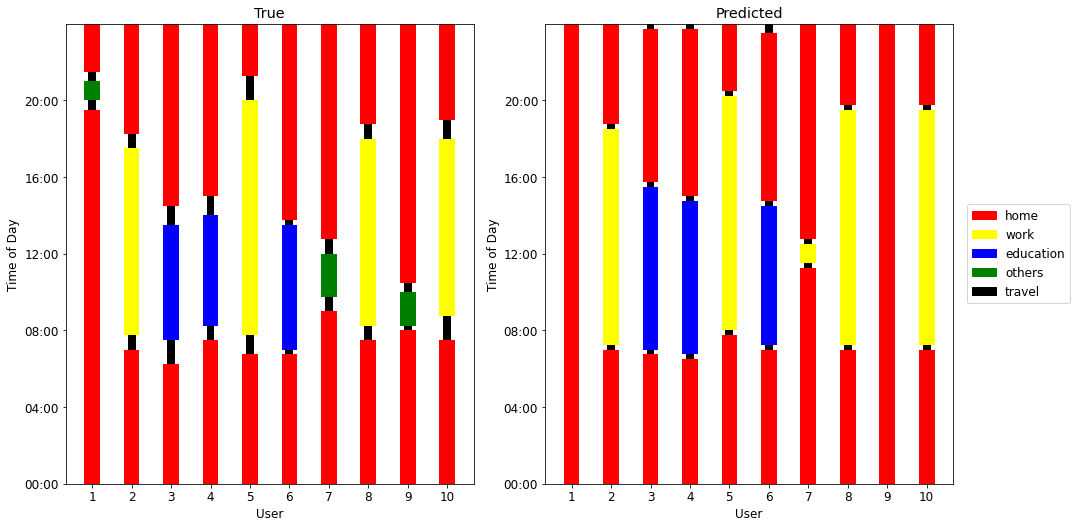

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Example dataset structure
# Each day has a list of tuples with (color, start time, duration)
# This allows any color, including 'Discon', to appear at any position

# Create a color map for the areas including 'Discon'
colors = {
    'home': 'red',
    'work': 'yellow',
    'education': 'blue',
    'others': 'green',
    'travel': 'black'  # Disconnection is black
}

# Initialize a figure
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

# Plot each day's events
# Plot each day's events
for k in range(2):
    data = test_tuples if k == 0 else learner_tuples
    for i, (day, events) in enumerate(data.items()):
        for event in events:
            # print(event)
            area, start, duration = event
            # Define the width of the bar. If the event is a 'Discon', make it narrower
            width = 0.2 if area == 'travel' else 0.4
            # The position of the bar is the same for all, 'align' is 'center' so it should align properly
            ax[k].bar(i, duration, bottom=start, width=width, color=colors[area], align='center')

    # Set the x-axis labels
    ax[k].set_xticks(range(len(data)))
    ax[k].set_xticklabels(np.arange(1, 11))

    # Set the y-axis label
    ax[k].set_xlabel("User")
    ax[k].set_ylabel('Time of Day')
    
    ax[k].set_ylim([0, 96])
    ax[k].set_yticks(range(0, 96, 16))
    ax[k].set_yticklabels(["00:00", "04:00", "08:00", "12:00", "16:00", "20:00"])
    
    # Set the title
    ax[k].set_title('True' if k == 0 else 'Predicted')

# Create a custom legend
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=area) for area, color in colors.items()]
ax[1].legend(handles=legend_patches, bbox_to_anchor=(1.3, 0.5), loc='center right')

# Show the plot
plt.tight_layout()
# plt.show()
plt.savefig("../result/true_predict_examples(nonwork).png", dpi=300)

# Visualize reward

In [17]:
import pandas as pd

df = pd.read_csv("../data/singapore/test_act_trip_data_filter_user.csv")
print(df.columns)

# age, gender, income

Index(['user', 'date', 'age', 'gender', 'car', 'employ', 'income',
       'postal_code', 'act_trip_seq96', 'nonwork_act_trip_seq96', 'workday'],
      dtype='object')


In [18]:
import numpy as np

test_reward = np.load("../result/f_test_set_all.npy")
print(test_reward.shape)

(3849, 96)


### heatmap plot

/tmp/ipykernel_699138/1083085146.py:51: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


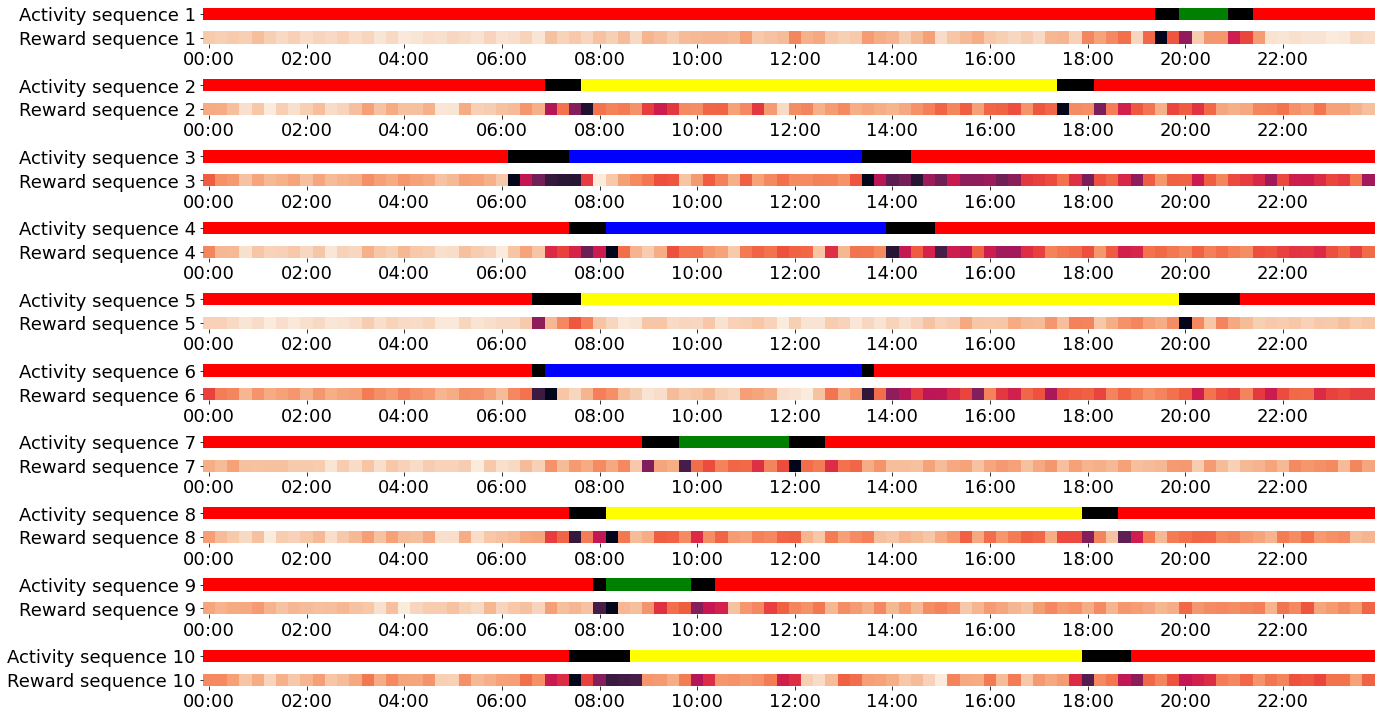

In [30]:
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
# matplotlib.rcParams.update({'font.size': 30})

fig, axs = plt.subplots(30, 1, figsize=(21, 13))

for user in range(10):
    sample_trajs = test_trajs[sample_idx[user]:sample_idx[user]+1] + 1
    # Example categorical data array
    # Each integer represents a different category

    custom_colors = ['red', 'yellow', 'blue', 'green', 'black']  # Replace with your colors

    # Create a ListedColormap with your custom color list
    cmap = ListedColormap(custom_colors)

    # Create the heatmap using seaborn
    sns.heatmap(sample_trajs, cmap=cmap, cbar=False, ax=axs[user*3], square=True, 
                xticklabels=False, yticklabels=False)    
    axs[user*3].set_yticks([0.5])
    axs[user*3].set_yticklabels([f"Activity sequence {user+1}"])
    # Set the title

    sample_reward_seq = test_reward[sample_idx[user]:sample_idx[user]+1]
    sns.heatmap(sample_reward_seq, ax=axs[user*3+1], square=True, cbar=False, 
                xticklabels=False, yticklabels=False)
    
    
    # custom_labels = [f"{i//4}:00" if i % 4 == 0 else '' for i in range(96)]
    # Set the custom labels and rotation
    
    # custom_labels = [f"{i//4}h" for i in range(0, 96, 8)]
    custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]
    # Set the custom labels and rotation
    axs[user*3+1].set_xticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
    axs[user*3+1].set_xticklabels(custom_labels, rotation=0)
    
    # axs[user*3+1].set_xticks(np.arange(96))  # Positioning the labels at the center of the cells
    # axs[user*3+1].set_xticklabels(custom_labels, rotation=0)
    axs[user*3+1].set_yticks([0.5])
    axs[user*3+1].set_yticklabels([f"Reward sequence {user+1}"])
    
    axs[user*3+2].set_visible(False)

plt.subplots_adjust(hspace=0.4)
fig.tight_layout()

plt.savefig("../result/reward_examples(nonwork).png", dpi=300, bbox_inches='tight')

# Show the plot
# plt.show()

### activity diff plot

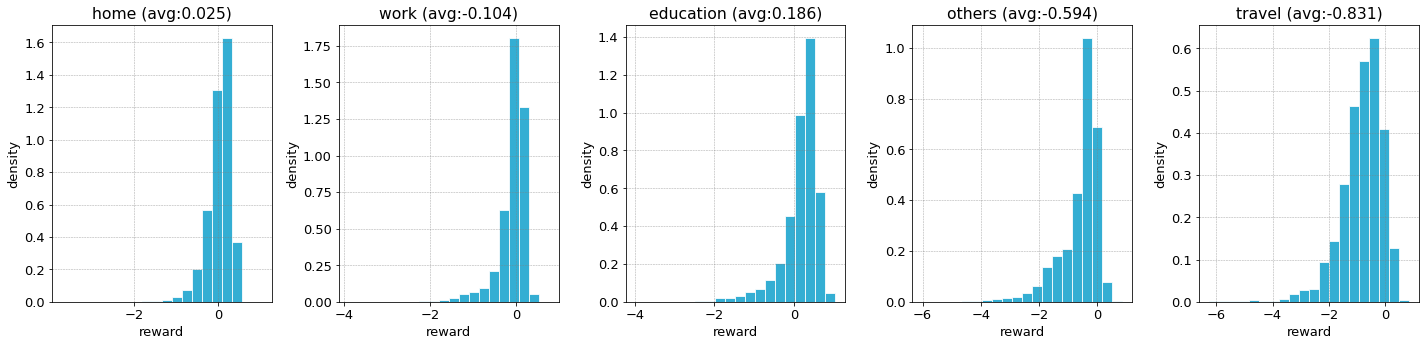

In [28]:
# , density=True
def plot(test_trajs, test_reward):
  matplotlib.rcParams.update({'font.size': 13})
  # plt.rcParams['font.family'] = 'serif'
  # plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
  fig, axs = plt.subplots(1, 5, figsize=(20, 5))
  # "/content/gdrive/My Drive/LLM4DemandPred/data/terminal5/terminal5_daily_demand.csv"
  activities = ["home", "work", "education", "others", "travel"]
  for i in range(5):
        sample_reward = test_reward[test_trajs == i]
        axs[i].hist(sample_reward, color="#019AC9", edgecolor="white", alpha=0.8, bins=20, density=True)
        axs[i].set_xlabel("reward")
        axs[i].set_ylabel("density")
        axs[i].set_title(f"{activities[i]} (avg:{np.mean(sample_reward):.3f})")
        axs[i].grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
  fig.tight_layout()
  plt.savefig("../result/reward_distribution.png", dpi=300)

plot(test_trajs, test_reward)

## Cluster reward sequence

In [18]:
train_reward = np.load("../result/f_train_set_all.npy")
test_reward = np.load("../result/f_test_set_all.npy")
train_test_reward = np.concatenate([train_reward, test_reward], 0)
print(train_test_reward.shape)

(19241, 96)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Example 2-D numpy array data

# Determine the optimal number of clusters using the elbow method
sse = []  # Sum of squared errors
cluster_labels_ls = []
centroids_ls = []
for k in range(1, 10):  # Test values of k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_test_reward)
    sse.append(kmeans.inertia_)  # Inertia: Sum of squared distances to closest cluster center
    cluster_labels_ls.append(kmeans.labels_)
    centroids_ls.append(kmeans.cluster_centers_)
# Plot SSE to find the elbow
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 11), sse, marker='o')
# plt.title('Elbow Method to Determine Optimal k')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Sum of Squared Errors (SSE)')
# plt.xticks(range(1, 11))
# plt.grid(True)
# plt.show()

In [21]:
cluster_labels = np.stack(cluster_labels_ls, 0)
print(cluster_labels.shape)

(4, 19241)


In [22]:
train_cluster_labels = cluster_labels[:, :len(train_trajs)]
test_cluster_labels = cluster_labels[:, len(train_trajs):]
print(train_cluster_labels.shape)
print(test_cluster_labels.shape)

np.save("../result/cluster_train_set_all.npy", train_cluster_labels)
np.save("../result/cluster_test_set_all.npy", test_cluster_labels)

(4, 15392)
(4, 3849)


In [20]:
train_cluster_labels = np.load("../result/cluster_train_set_all.npy")
test_cluster_labels = np.load("../result/cluster_test_set_all.npy")
all_cluster_labels = np.concatenate([train_cluster_labels, test_cluster_labels], -1)
print(all_cluster_labels.shape)

(10, 19241)


(100, 96)
(100, 96)
(100, 96)
(100, 96)


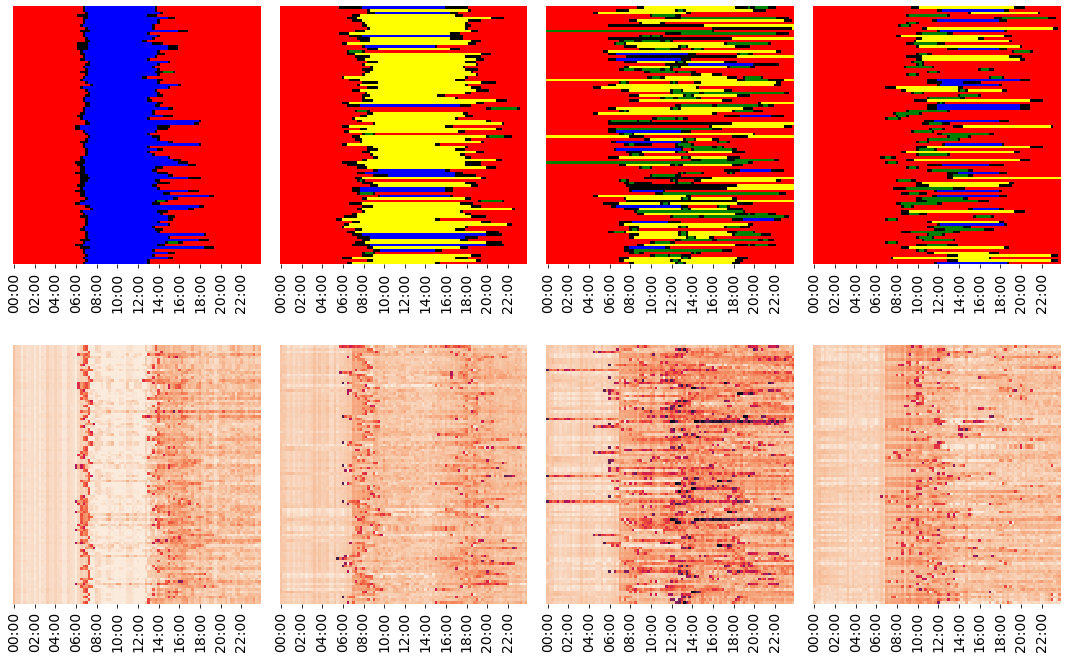

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
# matplotlib.rcParams.update({'font.size': 30})

n_cluster = 4
n_sample = 100
fig, axs = plt.subplots(2, n_cluster, figsize=(15, 10))

cluster_labels = cluster_labels_ls[n_cluster - 1]

for cluster in range(n_cluster):
    sample_trajs = test_trajs[cluster_labels[-len(test_trajs):] == cluster]
    sample_reward = test_reward[cluster_labels[-len(test_trajs):] == cluster]
    rand_idx = np.random.choice(len(sample_trajs), n_sample)
    sample_trajs = sample_trajs[rand_idx]
    sample_reward = sample_reward[rand_idx]
    print(sample_trajs.shape)
    # Example categorical data array
    # Each integer represents a different category

    custom_colors = ['red', 'yellow', 'blue', 'green', 'black']  # Replace with your colors

    # Create a ListedColormap with your custom color list
    cmap = ListedColormap(custom_colors)

    # Create the heatmap using seaborn
    sns.heatmap(sample_trajs, cmap=cmap, cbar=False, ax=axs[0, cluster], 
                square=True, xticklabels=False, yticklabels=False)
    # axs[0, cluster].set_title(f"Activity Sequence: cluster{cluster+1}")
    # Set the title

    custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]
    # Set the custom labels and rotation
    axs[0, cluster].set_xticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
    axs[0, cluster].set_xticklabels(custom_labels, rotation=90, fontsize=14)
    
    # fulltime_sample_trajs = test_trajs[(cluster_labels[-len(test_trajs):] == cluster) & (test_ind_emp == 4)][:n_sample]
    # sns.heatmap(fulltime_sample_trajs, cmap=cmap, cbar=False, ax=axs[1, cluster], square=True, xticklabels=False, yticklabels=False)
    # axs[1, cluster].set_title(f"Activity Sequence: cluster{cluster}")
    # axs[1, cluster].set_xticks(np.arange(96))  # Positioning the labels at the center of the cells
    # axs[1, cluster].set_xticklabels(custom_labels, rotation=90)
    sns.heatmap(sample_reward, ax=axs[1, cluster], square=True, cbar=False, xticklabels=False, 
                yticklabels=False, vmin=-4, vmax=0.5)
    # axs[1, cluster].set_title(f"Reward Sequence: cluster{cluster+1}")
    # custom_labels = [f"{i//4}:00" if i % 8 == 0 else '' for i in range(96)]
    custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]
    # Set the custom labels and rotation
    axs[1, cluster].set_xticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
    axs[1, cluster].set_xticklabels(custom_labels, rotation=90, fontsize=14)
    
    # axs[user*3+2].set_visible(False)
# # axs[1].set_title("Reward Sequence")
# plt.subplots_adjust(hspace=0.4)
fig.tight_layout()

# Show the plot
plt.savefig("../result/reward_sequence_clusters.png", dpi=300)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


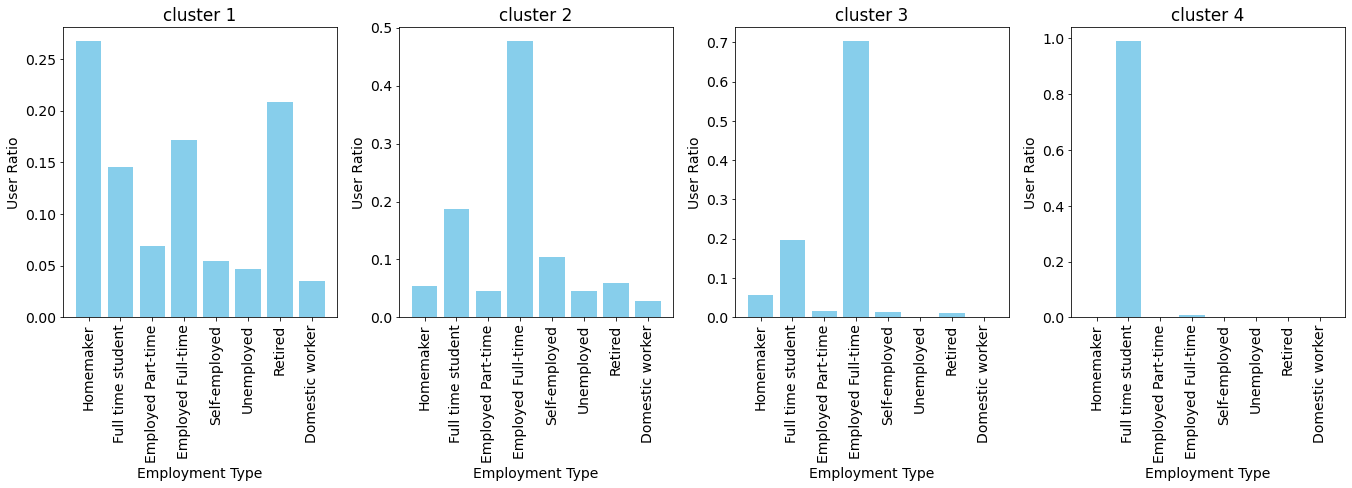

In [ ]:
"""plot socio-demographic features of clusters"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matplotlib.rcParams.update({'font.size': 14, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
# matplotlib.rcParams.update({'font.size': 30})

employ_dict = {'Homemaker': 0, 
               'Full time student': 1, 
               'Voluntary worker': 2, 
               'Employed Part-time': 3, 
               'Employed Full-time': 4, 
               'Non schooling child': 5, 
               'Self-employed': 6, 
               'National service': 7, 
               'Unemployed': 8, 
               'Retired': 9, 
               'Domestic worker': 10}

n_cluster = 4


fig, axs = plt.subplots(1, n_cluster, figsize=(19, 7))
for cluster_id in range(n_cluster):
    sample_cluster_feat = test_ind_feat[test_cluster_labels[n_cluster-1] == cluster_id]
    sample_emp = test_ind_emp[test_cluster_labels[n_cluster-1] == cluster_id]
    sample_emp_mask = (sample_emp == 2) + (sample_emp == 5) + (sample_emp == 7)
    sample_cluster_feat = sample_cluster_feat[sample_emp_mask == 0]
    sample_emp = sample_emp[sample_emp_mask == 0]
    emp_comp = []
    emp_labels = []
    for emp in employ_dict:
        if employ_dict[emp] in [2,5,7]: continue
        emp_comp.append(sum(sample_emp==employ_dict[emp]) / len(sample_emp))
        emp_labels.append(emp)
        
    axs[cluster_id].bar(np.arange(len(emp_comp)), emp_comp, color='skyblue')
    axs[cluster_id].set_title(f"cluster {cluster_id+1}")

    axs[cluster_id].set_xticks(np.arange(len(employ_dict) - 3))  # X-ticks positions should start from 1
    axs[cluster_id].set_xticklabels(emp_labels, rotation=90)

    axs[cluster_id].set_xlabel('Employment Type')
    axs[cluster_id].set_ylabel('User Ratio')  # Corrected method name for setting y-label
fig.tight_layout()
plt.savefig("../result/employment_type_clusters.png", dpi=300)

# Visualize long-term return

In [39]:
# test_trajs
# test_reward
def compute_traj_return(test_reward, gamma = 0.99):
    time_return = test_reward[:, -1]
    test_return = np.zeros_like(test_reward)
    test_return[:, -1] = test_reward[:, -1]
    for i in reversed(range(95)):
        test_return[:, i] = test_reward[:, i] + gamma * test_return[:, i+1] 
    np.save("../result/return_test_set_all.npy", test_return)

train_reward = np.load("../result/f_test_set.npy")
compute_traj_return(train_reward)

In [50]:
train_test_trajs = np.concatenate([train_trajs, test_trajs], 0)
print(train_test_trajs.shape)

train_reward = np.load("../result/f_train_set.npy")
test_reward = np.load("../result/f_test_set.npy")
train_test_reward = np.concatenate([train_reward, test_reward], 0)
print(train_test_reward.shape)

train_return = np.load("../result/return_train_set.npy")
test_return = np.load("../result/return_test_set.npy")
train_test_return = np.concatenate([train_return, test_return], 0)
print(train_test_return.shape)

train_test_ind_feat = np.concatenate([train_ind_feat, test_ind_feat], 0)
print(train_test_ind_feat.shape)

train_test_ind_emp = np.concatenate([train_ind_emp[:, None], test_ind_emp[:, None]], 0)[:, 0]
print(train_test_ind_emp.shape)

(19241, 96)
(19241, 96)
(19241, 96)
(19241, 5)
(19241,)


In [51]:
test_reward = np.load("../result/f_test_set.npy")
test_return = np.load("../result/return_test_set.npy")

664


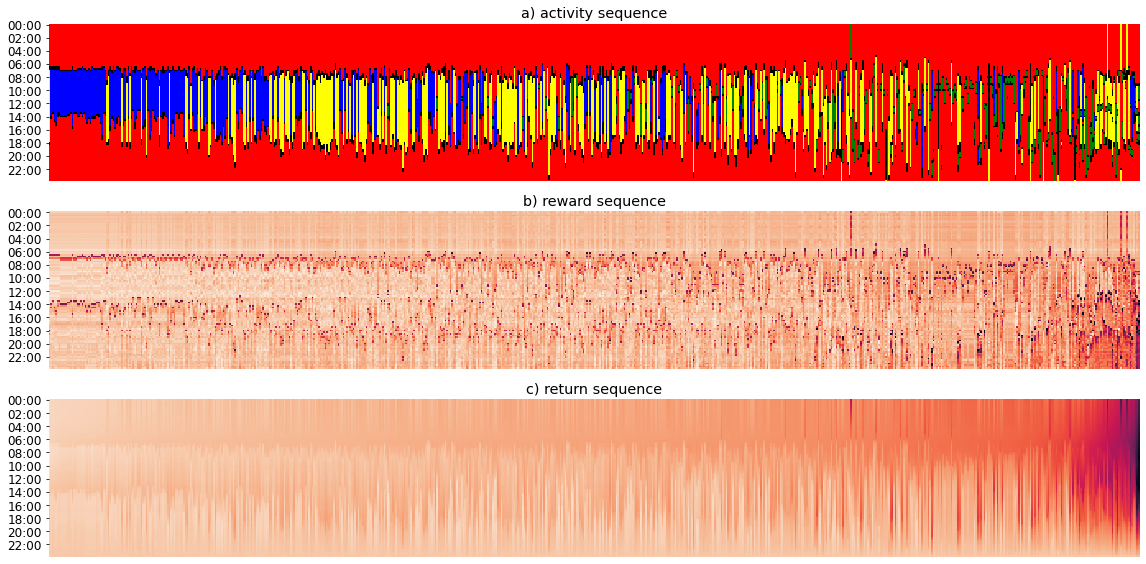

In [ ]:
def plot(test_trajs, test_reward, test_return, test_ind_feat, test_ind_emp, time_idx=0, n_trajs=100, n_quantile=4):
  matplotlib.rcParams.update({'font.size': 12})

  """plot"""
  matplotlib.rcParams.update({'font.size': 12, 'font.family': 'serif', 'font.serif': 'Times New Roman'})

  """print activity sequence of different return groups"""
  fig, axs = plt.subplots(3, 1, figsize=(22, 8))
  custom_colors = ['red', 'yellow', 'blue', 'green', 'black']  # Replace with your colors
  cmap = ListedColormap(custom_colors)

  # test_trajs = test_trajs[test_ind_emp == 4]
  # test_reward = test_reward[test_ind_emp == 4]
  # test_return = test_return[test_ind_emp == 4]
  # test_ind_feat = test_ind_feat[test_ind_emp == 4]
    
  time_return_df = pd.DataFrame(data={"return": test_return[:, time_idx]})
  time_return_df.sort_values(by="return", ascending=False, inplace=True)
  sorted_idx = time_return_df.index
  sorted_trajs = test_trajs[sorted_idx]
  sorted_reward = test_reward[sorted_idx]
  sorted_return = test_return[sorted_idx]
  sorted_ind_feat = test_ind_feat[sorted_idx]
  sorted_ind_emp = test_ind_emp[sorted_idx]
  # sorted_return = time_return_df["return"].values

  sample_idx = np.arange(0, len(sorted_return), int(len(sorted_return) / 650))
  print(len(sample_idx))
  sample_trajs = sorted_trajs[sample_idx]
  sample_reward = sorted_reward[sample_idx]
  sample_ind_feat = sorted_ind_feat[sample_idx]
  sample_ind_emp = sorted_ind_emp[sample_idx]
  sample_return = sorted_return[sample_idx]

  sns.heatmap(np.transpose(sample_trajs), cmap=cmap, cbar=False, ax=axs[0], square=True, xticklabels=False, yticklabels=False)
  # axs.set_title(f"{int(m*(100/n_quantile))}%-{int((m+1)*(100/n_quantile))}% | {np.mean(sample_return):.3f}")
  custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]  
  axs[0].set_yticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
  axs[0].set_yticklabels(custom_labels)
  axs[0].set_title("a) activity sequence")
    
  sns.heatmap(np.transpose(sample_reward), cbar=False, ax=axs[1], square=True, xticklabels=False, 
              yticklabels=False, vmin=-4, vmax=0.5)
  # axs.set_title(f"{int(m*(100/n_quantile))}%-{int((m+1)*(100/n_quantile))}% | {np.mean(sample_return):.3f}")
  custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]  
  axs[1].set_yticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
  axs[1].set_yticklabels(custom_labels)
  axs[1].set_title("b) reward sequence")

  sns.heatmap(np.transpose(sample_return), cbar=False, ax=axs[2], square=True, xticklabels=False, yticklabels=False)
  # axs.set_title(f"{int(m*(100/n_quantile))}%-{int((m+1)*(100/n_quantile))}% | {np.mean(sample_return):.3f}")
  custom_labels = [f"{i//4:02d}:00" for i in range(0, 96, 8)]  
  axs[2].set_yticks(np.arange(0.5, 96, 8))  # Positioning the labels at the center of the cells
  axs[2].set_yticklabels(custom_labels)
  axs[2].set_title("c) return sequence")

  fig.tight_layout()
  plt.savefig("../result/sorted_return_sequence.png", dpi=300)

plot(train_test_trajs, train_test_reward, train_test_return, train_test_ind_feat, train_test_ind_emp, time_idx=24, n_trajs=200, n_quantile=4)

19241 0 4810
19241 4810 9620
19241 9620 14430
19241 14430 19241
[0.1423658782149348, 0.33367721858287896, 0.414623622170792, 0.4608346438782193]
[0.2388773388773389, 0.3760914760914761, 0.6617463617463617, 0.7503637497401787]
[0.20852390852390854, 0.36881496881496884, 0.21891891891891893, 0.22926626480981085]
[0.0946802005625535, 0.22922220863397333, 0.20858505564387916, 0.12009243522809249]
0
25
50
75


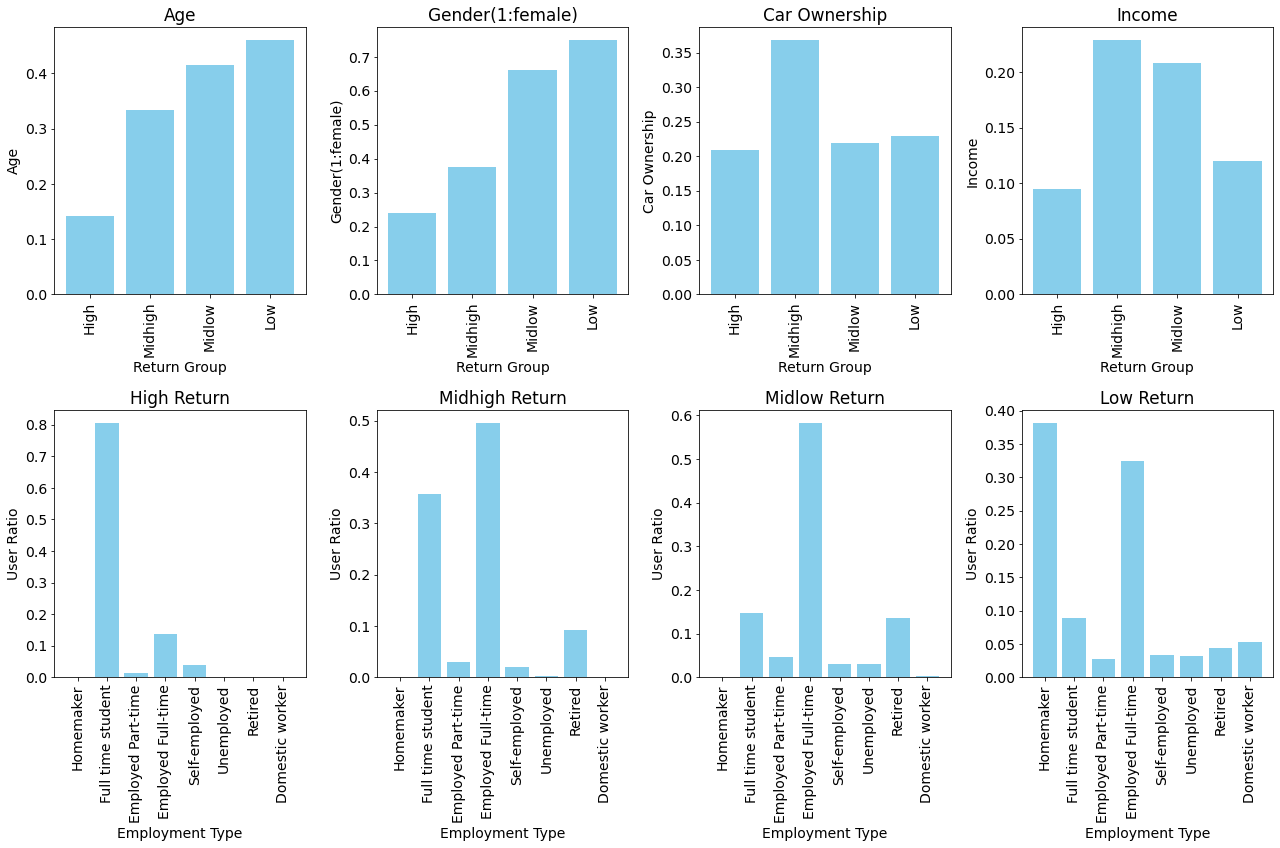

In [60]:
"""plot socio-demographic features of clusters"""
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

matplotlib.rcParams.update({'font.size': 14, 'font.family': 'serif', 'font.serif': 'Times New Roman'})
# matplotlib.rcParams.update({'font.size': 30})

time_return_df = pd.DataFrame(data={"return": train_test_return[:, 0]})
time_return_df.sort_values(by="return", ascending=False, inplace=True)
sorted_idx = time_return_df.index
sorted_trajs = train_test_trajs[sorted_idx]
sorted_reward = train_test_reward[sorted_idx]
sorted_return = train_test_return[sorted_idx]
sorted_ind_feat = train_test_ind_feat[sorted_idx]
sorted_ind_emp = train_test_ind_emp[sorted_idx]
    
employ_dict = {'Homemaker': 0, 
               'Full time student': 1, 
               'Voluntary worker': 2, 
               'Employed Part-time': 3, 
               'Employed Full-time': 4, 
               'Non schooling child': 5, 
               'Self-employed': 6, 
               'National service': 7, 
               'Unemployed': 8, 
               'Retired': 9, 
               'Domestic worker': 10}

n_cluster = 4

fig, axs = plt.subplots(2, 4, figsize=(18, 12))
sample_ind_feat_ls = []
for quantile in range(0, 100, 25):
    start_idx = int(len(sorted_ind_feat) * (quantile /100))
    end_idx = int(len(sorted_ind_feat) * ((quantile+25)/100))
    print(len(sorted_ind_feat), start_idx, end_idx)
    sample_ind_feat_ls.append(sorted_ind_feat[start_idx:end_idx])
for i, feat in enumerate(["Age", "Gender(1:female)", "Car Ownership", "Income"]):
    mean_values = [np.mean(sample_ind_feat[:, i]) for sample_ind_feat in sample_ind_feat_ls]
    print(mean_values)
    axs[0, i].bar(np.arange(len(mean_values)), mean_values, color='skyblue')

    axs[0, i].set_title(feat)

    num_groups = len(sample_ind_feat_ls)  # Assuming this is the correct number of groups/categories

    axs[0, i].set_xticks(np.arange(n_cluster))  # X-ticks positions should start from 1
    axs[0, i].set_xticklabels(["High", "Midhigh", "Midlow", "Low"], rotation=90)

    axs[0, i].set_xlabel('Return Group')
    axs[0, i].set_ylabel(feat)  # Corrected method name for setting y-label
# fig.tight_layout()
# plt.savefig("../result/return_socio_dem.png", dpi=300)

# fig, axs = plt.subplots(1, n_cluster, figsize=(19, 5))
titles = ["High Return", "Midhigh Return", "Midlow Return", "Low Return"]
for cluster_id, quantile in enumerate(range(0, 100, 25)):
    print(quantile)
    start_idx = int(len(sorted_ind_feat) * (quantile /100))
    end_idx = int(len(sorted_ind_feat) * ((quantile+25)/100))
    sample_emp = sorted_ind_emp[start_idx:end_idx]
    sample_emp_mask = (sample_emp == 2) + (sample_emp == 5) + (sample_emp == 7)
    sample_emp_mask = sample_emp_mask[sample_emp_mask == 0]
    emp_comp = []
    emp_labels = []
    for emp in employ_dict:
        if employ_dict[emp] in [2,5,7]: continue
        emp_comp.append(sum(sample_emp==employ_dict[emp]) / len(sample_emp))
        emp_labels.append(emp)
        
    axs[1, cluster_id].bar(np.arange(len(emp_comp)), emp_comp, color='skyblue')
    axs[1, cluster_id].set_title(titles[cluster_id])

    axs[1, cluster_id].set_xticks(np.arange(len(employ_dict) - 3))  # X-ticks positions should start from 1
    axs[1, cluster_id].set_xticklabels(emp_labels, rotation=90)

    axs[1, cluster_id].set_xlabel('Employment Type')
    axs[1, cluster_id].set_ylabel('User Ratio')  # Corrected method name for setting y-label
fig.tight_layout()
plt.savefig("../result/return_socio_demographics.png", dpi=300)